# 0. Introduction

### What are Support and Resistance 

Support and resistance are key concepts in technical analysis, reflecting the levels at which a stock price tends to stop and reverse its direction. A support level is where the price tends to find a floor as it falls, while a resistance level is where the price tends to face a ceiling as it rises. These levels indicate where supply and demand forces meet, leading to a balance in the price movement. When the price breaks through these levels, it often signals a significant shift in market sentiment, potentially leading to a sharp move in the direction of the breakout.

Support and resistance levels, while widely used in market trading, can be inaccurate due to their inherent subjectivity and the dynamic nature of financial markets. These levels are often drawn based on historical price points, but market conditions, such as sudden news events, shifts in market sentiment, or changes in liquidity, can cause prices to break through these levels unpredictably. 

### What is RSRS (Resistance Support Relative Strength)?

RSRS is a technical indicator mentioned in this section, which refers to the concept of evaluating the strength of support and resistance levels relative to one another. The idea is to assess whether a given support or resistance level is stronger or weaker relative to other levels, thereby providing a more nuanced understanding of potential price movements.

The chosen proxy for support and resistance levels is based on the highest and lowest prices observed daily. The highest price of the day is considered a potential resistance level, and the lowest price is considered a support level. These prices reflect the collective actions and expectations of market participants. The relative strength between support and resistance is quantified by the ratio of changes in these proxy variables. Specifically, the relative strength is described using the ratio of the changes in the highest price (delta high) to the changes in the lowest price (delta low). This ratio captures how much the highest price changes relative to the lowest price.

##### Mathematical Model for RSRS

$$ 
\text{high} = \alpha + \beta \times \text{low} + \epsilon, \quad \epsilon \sim N(0, \sigma)
$$

| **Circumstance** | **Explanation** |
|------------------|-----------------|
| **High Beta in Bull Market** | **Trend**: The highest prices increase faster than the lowest prices, indicating strong bullish momentum. <br> **Implication**: Resistance is weaker than support, suggesting significant upward potential. |
| **High Beta in Bear Market** | **Trend**: The highest prices decrease faster than the lowest prices, indicating a strong bearish trend. <br> **Implication**: Resistance is strong, and the market is likely to continue falling. |
| **Low Beta in Bull Market** | **Trend**: The highest prices increase slower than the lowest prices, indicating a weakening bullish trend. <br> **Implication**: Support is stronger than resistance, signaling limited upward potential. |
| **Low Beta in Bear Market** | **Trend**: The highest prices decrease slower than the lowest prices, indicating a weakening bearish trend. <br> **Implication**: Support is beginning to strengthen, suggesting that the downward pressure is not as strong. |

# 1. Initial Implementation of RSRS. Compare Result with CSI 300

The CSI 300 is a capitalization-weighted stock market index designed to replicate the performance of the top 300 stocks traded on the Shanghai Stock Exchange and the Shenzhen Stock Exchange.

### 1.1 Import Library and Data 

In [157]:
import akshare as ak
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rcParams['font.family'] = 'STKAITI' 
# plt.rcParams['axes.unicode_minus'] = False   
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
import seaborn as sns

In [158]:
index_code = "sh000300"
#index_code = 'SPY'
start_date = pd.to_datetime("2005-01-01")
end_date = pd.to_datetime("2023-01-01")
Market = ak.stock_zh_index_daily(symbol = index_code)
Market['date'] = pd.to_datetime(Market['date'])
Market = Market[(Market['date']>= start_date) & (Market['volume']> 0) & (Market['date']<= end_date)]
Market = Market.set_index('date')
Market['Daily_Return'] = Market['close'].pct_change().dropna()
Market['Cumulative_Return'] = np.cumprod(Market['close'].pct_change() + 1)
Market = Market#.dropna()

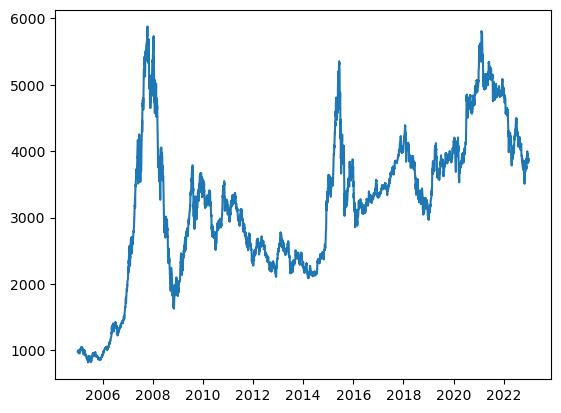

In [159]:
plt.plot(Market['close'])

### 1.2 Generate RSRS Indicator 

In [160]:
# Set the number of observations to be used in the RSRS calculation
Number_Observation = 20

# Initialize arrays to store beta coefficients and R-squared values, filled with NaN, having the same length as the number of rows in the Market dataset
beta = np.full(Market.shape[0], np.nan)
r_squared = np.full(Market.shape[0], np.nan)

In [161]:
# Define the RSRS_Signal function, which takes a dataset, the number of observations, and the length of the dataset as inputs
def RSRS_Signal(Dataset, Number_Observation, Length):
    
    # Loop through the dataset starting from 'Number_Observation' to 'Length'
    for i in range(Number_Observation, Length + 1):
        # Select the 'high' prices as the dependent variable (y) for the past 'Number_Observation' days
        y = Dataset['high'].iloc[i - Number_Observation:i].values
        
        # Select the 'low' prices as the independent variable (X) and add a column of ones for the intercept term
        X = np.c_[np.ones(Number_Observation), Dataset['low'].iloc[i - Number_Observation:i].values]

        # Create a linear regression model
        model = LinearRegression()
        
        # Fit the model using the selected high (y) and low (X) prices
        model.fit(X, y)
        
        # Store the slope (beta coefficient) of the fitted line, which is the second coefficient in the model
        beta[i - 1] = model.coef_[1]
        
        # Store the R-squared value of the fitted model to measure the goodness of fit
        r_squared[i - 1] = model.score(X, y)

    # Add the computed beta coefficients and R-squared values as new columns to the dataset
    Dataset['rsrs_beta'] = beta
    Dataset['r_squared'] = r_squared

#    Market.dropna(inplace= True)

In [162]:
# Call the RSRS_Signal function with the Market dataset, the number of observations, and the length of the dataset
RSRS_Signal(Market, Number_Observation, len(Market))

In [163]:
Market

,open,high,low,close,volume,Daily_Return,Cumulative_Return,rsrs_beta,r_squared
date,,,,,,,,,
2005-01-04,994.769,994.769,980.658,982.794,741286894,NaN,NaN,NaN,NaN
2005-01-05,981.577,997.323,979.877,992.564,711910898,0.009941,1.009941,NaN,NaN
2005-01-06,993.331,993.788,980.330,983.174,628802905,-0.009460,1.000387,NaN,NaN
2005-01-07,983.045,995.711,979.812,983.958,729869409,0.000797,1.001184,NaN,NaN
2005-01-10,983.760,993.959,979.789,993.879,579169799,0.010083,1.011279,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-12-26,3830.568,3856.807,3827.519,3843.489,7300571200,0.003989,3.910778,0.890240,0.892293
2022-12-27,3860.905,3891.850,3856.580,3887.854,7751535000,0.011543,3.955920,0.964048,0.901101
2022-12-28,3874.913,3884.721,3854.941,3871.264,8442465600,-0.004267,3.939039,0.960882,0.895619


### 1.2.1 Explore the distribution of beta 

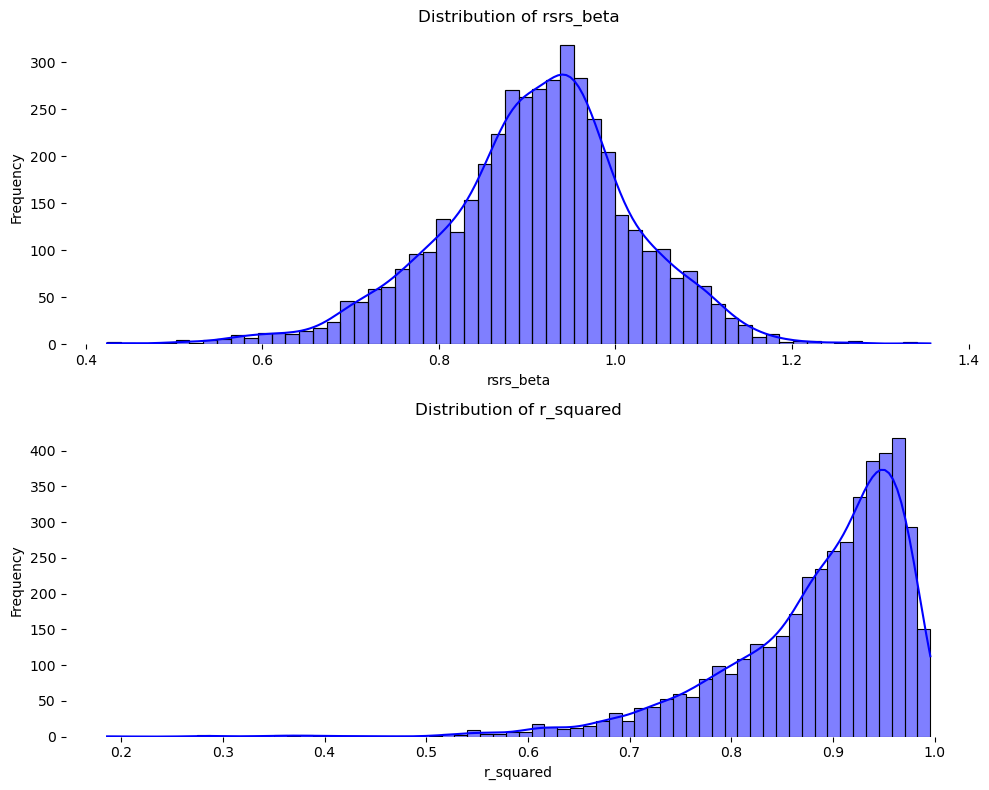

In [164]:
# Create a figure with a specified size of 10x8 inches
plt.figure(figsize=(10, 8))

# Create the first subplot for the distribution of 'rsrs_beta'
ax1 = plt.subplot(2, 1, 1)

# Plot a histogram with a kernel density estimate (KDE) for the 'rsrs_beta' column, excluding NaN values, in blue color
sns.histplot(Market['rsrs_beta'].dropna(), kde=True, color='blue', ax=ax1)

# Set the title, x-axis label, and y-axis label for the first subplot
ax1.set_title('Distribution of rsrs_beta')
ax1.set_xlabel('rsrs_beta')
ax1.set_ylabel('Frequency')

# Hide the top, right, left, and bottom spines (borders) of the first subplot for a cleaner look
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Create the second subplot for the distribution of 'r_squared'
ax2 = plt.subplot(2, 1, 2)

# Plot a histogram with a KDE for the 'r_squared' column, excluding NaN values, in blue color
sns.histplot(Market['r_squared'].dropna(), kde=True, color='blue', ax=ax2)
# Set the title, x-axis label, and y-axis label for the second subplot
ax2.set_title('Distribution of r_squared')
ax2.set_xlabel('r_squared')
ax2.set_ylabel('Frequency')
# Hide the top, right, left, and bottom spines of the second subplot for a cleaner look
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Adjust the layout so that subplots do not overlap
plt.tight_layout()

# Display the plots
plt.show()


In [165]:
from scipy.stats import skew, kurtosis
from matplotlib.table import Table

def calculate_statistics(data):
    # Compute the statistical parameter and display them
    mean = round(np.mean(data), 4)
    STD = round(np.std(data), 4)
    skewness = round(skew(data), 4)
    Kurtosis = round(kurtosis(data), 4)
    return mean, STD, skewness, Kurtosis


In [166]:
def plot_statistics(dataframe):
    # Plot the table
    fig, ax = plt.subplots(figsize=(6, 2))  # Adjust the size as needed
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

    # Set table style
    table.auto_set_font_size(False)
    table.set_fontsize(14)  # Increase the font size
    table.scale(8, 4)  # Increase the scale of the table (width, height)

    # Set custom colors for the header and cells
    header_color = '#730072'
    row_colors = ['#ece4f0', '#d4c5de']  # Alternating row colors

    # Set header color and remove grid lines
    for (i, j), cell in table.get_celld().items():
        cell.set_linewidth(0)  # Remove the grid lines inside the table
        if i == 0:  # Header row
            cell.set_fontsize(14)  # Adjust font size if necessary
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor(header_color)
        else:  # Data rows
            cell.set_facecolor(row_colors[i % len(row_colors)])  # Alternate row colors

    # Adjust the table appearance
    table.auto_set_column_width([0, 1, 2])  # Adjust column widths

    plt.show()

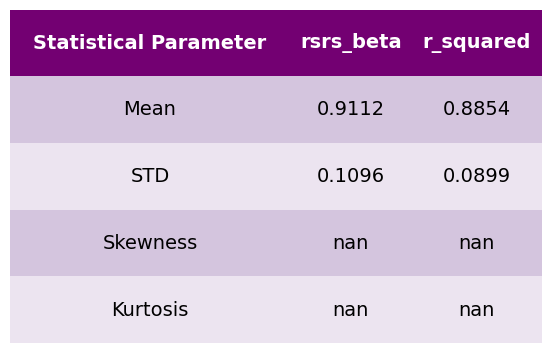

In [167]:
data = {
    "Statistical Parameter": ["Mean", "STD", "Skewness", "Kurtosis"],
    "rsrs_beta": calculate_statistics(Market['rsrs_beta']),
    "r_squared": calculate_statistics(Market['r_squared']),
}

df = pd.DataFrame(data)
plot_statistics(df)

### 1.3 Generate RSRS Standardized Indicator

The RSRS Standardized Indicator takes the RSRS slope indicator a step further by standardizing it to account for variability in the market. This involves calculating a Z-score for the slope.

**Key Differences**:

##### Purpose:

The **RSRS Slope Indicator** gives you a raw measure of the relative strength between support and resistance levels. It directly tells you whether support is strengthening or weakening compared to resistance.

The **RSRS Standardized Indicator** adjusts this raw measure to account for historical market conditions, providing a relative measure that factors in how unusual the current strength (or weakness) is compared to the past.

##### Computation:

The **RSRS Slope Indicator** only involves a linear regression to get the slope (
𝛽
) using the last 
𝑁
 days' data.

The **RSRS Standardized Indicator** requires additional steps, including computing the historical mean and standard deviation of slopes over a longer period 
𝑀
M to calculate a Z-score.

##### Interpretation:

The **RSRS Slope Indicator** is more straightforward and useful for a quick, direct assessment of market conditions.

The **RSRS Standardized Indicator** is more nuanced, allowing for comparison across different market regimes by showing how the current slope compares to historical norms.

In [168]:
Market

,open,high,low,close,volume,Daily_Return,Cumulative_Return,rsrs_beta,r_squared
date,,,,,,,,,
2005-01-04,994.769,994.769,980.658,982.794,741286894,NaN,NaN,NaN,NaN
2005-01-05,981.577,997.323,979.877,992.564,711910898,0.009941,1.009941,NaN,NaN
2005-01-06,993.331,993.788,980.330,983.174,628802905,-0.009460,1.000387,NaN,NaN
2005-01-07,983.045,995.711,979.812,983.958,729869409,0.000797,1.001184,NaN,NaN
2005-01-10,983.760,993.959,979.789,993.879,579169799,0.010083,1.011279,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-12-26,3830.568,3856.807,3827.519,3843.489,7300571200,0.003989,3.910778,0.890240,0.892293
2022-12-27,3860.905,3891.850,3856.580,3887.854,7751535000,0.011543,3.955920,0.964048,0.901101
2022-12-28,3874.913,3884.721,3854.941,3871.264,8442465600,-0.004267,3.939039,0.960882,0.895619


In [169]:
def compute_standardize_RSRS(Data, Window_M):

    # Calculate the rolling mean of the 'rsrs_beta' column over the specified window
    rolling_mean = Data['rsrs_beta'].rolling(window=Window_M).mean()

    # Calculate the rolling standard deviation of the 'rsrs_beta' column over the specified window
    rolling_std = Data['rsrs_beta'].rolling(window=Window_M).std()

    # Calculate the Z-score of the 'rsrs_beta' by subtracting the rolling mean and dividing by the rolling standard deviation
    Data['rsrs_zscore'] = (Data['rsrs_beta'] - rolling_mean) / rolling_std

In [170]:
compute_standardize_RSRS(Market, 600)
#Market.dropna(inplace = True)

In [171]:
Market

,open,high,low,close,volume,Daily_Return,Cumulative_Return,rsrs_beta,r_squared,rsrs_zscore
date,,,,,,,,,,
2005-01-04,994.769,994.769,980.658,982.794,741286894,NaN,NaN,NaN,NaN,NaN
2005-01-05,981.577,997.323,979.877,992.564,711910898,0.009941,1.009941,NaN,NaN,NaN
2005-01-06,993.331,993.788,980.330,983.174,628802905,-0.009460,1.000387,NaN,NaN,NaN
2005-01-07,983.045,995.711,979.812,983.958,729869409,0.000797,1.001184,NaN,NaN,NaN
2005-01-10,983.760,993.959,979.789,993.879,579169799,0.010083,1.011279,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-12-26,3830.568,3856.807,3827.519,3843.489,7300571200,0.003989,3.910778,0.890240,0.892293,-0.095173
2022-12-27,3860.905,3891.850,3856.580,3887.854,7751535000,0.011543,3.955920,0.964048,0.901101,0.495944
2022-12-28,3874.913,3884.721,3854.941,3871.264,8442465600,-0.004267,3.939039,0.960882,0.895619,0.473518


#### 1.31 Plot distribution of New Indicator

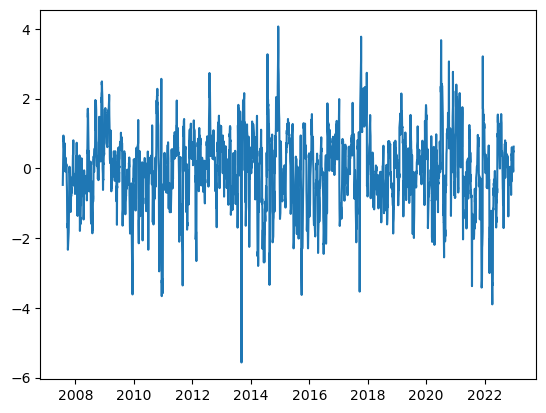

In [172]:
plt.plot(Market['rsrs_zscore'])

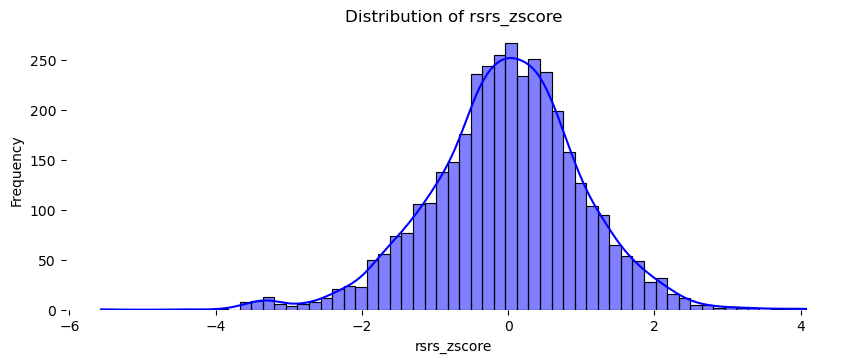

In [173]:
plt.figure(figsize = (10,8))

ax1 = plt.subplot(2,1,1)
sns.histplot(Market['rsrs_zscore'].dropna(), kde=True, color='blue', ax=ax1)
ax1.set_title('Distribution of rsrs_zscore')
ax1.set_xlabel('rsrs_zscore')
ax1.set_ylabel('Frequency')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

## 2. Evaluate Our Strategy Result using RSRS indicator

### 2.1 We will use 1 standard  deviation from mean as the indicator: above 1 STD we long and 1 STD below we short

It is pretty obvious that from the graph below, the average of beta fluctuates around 0.8 to 1, therefore our strategy stands 

#### 2.1.1 Compute RSRS Strategy Daily Return 

In [174]:
# Create a different dataset, we might use market dataset later on so we don't want to modify it right now 
RSRS_Strategy = Market.copy()

In [175]:
# Define a function to compute strategy returns based on RSRS beta values
def Compute_Strategy_Return(DF):
    
    # Inner function to calculate the trading signal based on the beta value
    def calculate_signal(beta):
        # If the beta is greater than 1, return a signal of 1 (indicating a buy signal)
        if beta > 1:
            return 1
        # If the beta is less than 0.8, return a signal of -1 (indicating a sell signal)
        if beta < 0.8:
            return -1
        # Otherwise, do not return anything (None), which implies no action

    # Create a new column 'Strategy_Signal' by applying the calculate_signal function to the shifted 'rsrs_beta' column
    # The shift is used to avoid look-ahead bias by using the previous day's beta value to make decisions
    DF['Strategy_Signal'] = DF['rsrs_beta'].shift(1).apply(calculate_signal)
    
    # Forward-fill any NaN values in the 'Strategy_Signal' column to propagate the last valid signal forward
    DF['Strategy_Signal'] = DF['Strategy_Signal'].fillna(method='ffill')
    
    # Replace any remaining NaN values with 0, indicating a neutral or no position
    DF['Strategy_Signal'] = DF['Strategy_Signal'].fillna(0)
    
    # Calculate the strategy's return by multiplying the daily return by the strategy signal
    # This reflects the gain or loss based on the buy (1), sell (-1), or neutral (0) signal
    DF['Strategy_Return'] = DF['Strategy_Signal'] * DF['Daily_Return']
    
    
Compute_Strategy_Return(RSRS_Strategy)
RSRS_Strategy

,open,high,low,close,volume,Daily_Return,Cumulative_Return,rsrs_beta,r_squared,rsrs_zscore,Strategy_Signal,Strategy_Return
date,,,,,,,,,,,,
2005-01-04,994.769,994.769,980.658,982.794,741286894,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2005-01-05,981.577,997.323,979.877,992.564,711910898,0.009941,1.009941,NaN,NaN,NaN,0.0,0.000000
2005-01-06,993.331,993.788,980.330,983.174,628802905,-0.009460,1.000387,NaN,NaN,NaN,0.0,-0.000000
2005-01-07,983.045,995.711,979.812,983.958,729869409,0.000797,1.001184,NaN,NaN,NaN,0.0,0.000000
2005-01-10,983.760,993.959,979.789,993.879,579169799,0.010083,1.011279,NaN,NaN,NaN,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,3830.568,3856.807,3827.519,3843.489,7300571200,0.003989,3.910778,0.890240,0.892293,-0.095173,-1.0,-0.003989
2022-12-27,3860.905,3891.850,3856.580,3887.854,7751535000,0.011543,3.955920,0.964048,0.901101,0.495944,-1.0,-0.011543
2022-12-28,3874.913,3884.721,3854.941,3871.264,8442465600,-0.004267,3.939039,0.960882,0.895619,0.473518,-1.0,0.004267


In [176]:
RSRS_Strategy['Strategy_Cumulative_Return'] = np.cumprod(RSRS_Strategy['Strategy_Return'] + 1)
RSRS_Strategy

,open,high,low,close,volume,Daily_Return,Cumulative_Return,rsrs_beta,r_squared,rsrs_zscore,Strategy_Signal,Strategy_Return,Strategy_Cumulative_Return
date,,,,,,,,,,,,,
2005-01-04,994.769,994.769,980.658,982.794,741286894,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2005-01-05,981.577,997.323,979.877,992.564,711910898,0.009941,1.009941,NaN,NaN,NaN,0.0,0.000000,1.000000
2005-01-06,993.331,993.788,980.330,983.174,628802905,-0.009460,1.000387,NaN,NaN,NaN,0.0,-0.000000,1.000000
2005-01-07,983.045,995.711,979.812,983.958,729869409,0.000797,1.001184,NaN,NaN,NaN,0.0,0.000000,1.000000
2005-01-10,983.760,993.959,979.789,993.879,579169799,0.010083,1.011279,NaN,NaN,NaN,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,3830.568,3856.807,3827.519,3843.489,7300571200,0.003989,3.910778,0.890240,0.892293,-0.095173,-1.0,-0.003989,6.121574
2022-12-27,3860.905,3891.850,3856.580,3887.854,7751535000,0.011543,3.955920,0.964048,0.901101,0.495944,-1.0,-0.011543,6.050914
2022-12-28,3874.913,3884.721,3854.941,3871.264,8442465600,-0.004267,3.939039,0.960882,0.895619,0.473518,-1.0,0.004267,6.076734


#### 2.1.2 Compute Daily Return for RSRS standarzied Score

In [177]:
RSRS_Standardize = Market.copy()
# Define function to compute standardized strategy returns based on RSRS z-score
def Compute_Standardize_Return(DF):
    
    # Calculate trading signal: 1 for buy, -1 for sell
    def calculate_signal(beta):
        if beta > 1:
            return 1
        if beta < -1:
            return -1

    # Create 'Strategy_Signal' using shifted 'rsrs_zscore' to avoid look-ahead bias
    DF['Strategy_Signal'] = DF['rsrs_zscore'].shift(1).apply(calculate_signal)
    
    # Fill missing values in 'Strategy_Signal' using forward fill and set remaining NaNs to 0
    DF['Strategy_Signal'] = DF['Strategy_Signal'].fillna(method='ffill').fillna(0)
    
    # Calculate strategy return by multiplying signal with daily return
    DF['Strategy_Return'] = DF['Strategy_Signal'] * DF['Daily_Return']
Compute_Standardize_Return(RSRS_Standardize)

In [178]:
RSRS_Standardize

,open,high,low,close,volume,Daily_Return,Cumulative_Return,rsrs_beta,r_squared,rsrs_zscore,Strategy_Signal,Strategy_Return
date,,,,,,,,,,,,
2005-01-04,994.769,994.769,980.658,982.794,741286894,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2005-01-05,981.577,997.323,979.877,992.564,711910898,0.009941,1.009941,NaN,NaN,NaN,0.0,0.000000
2005-01-06,993.331,993.788,980.330,983.174,628802905,-0.009460,1.000387,NaN,NaN,NaN,0.0,-0.000000
2005-01-07,983.045,995.711,979.812,983.958,729869409,0.000797,1.001184,NaN,NaN,NaN,0.0,0.000000
2005-01-10,983.760,993.959,979.789,993.879,579169799,0.010083,1.011279,NaN,NaN,NaN,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,3830.568,3856.807,3827.519,3843.489,7300571200,0.003989,3.910778,0.890240,0.892293,-0.095173,-1.0,-0.003989
2022-12-27,3860.905,3891.850,3856.580,3887.854,7751535000,0.011543,3.955920,0.964048,0.901101,0.495944,-1.0,-0.011543
2022-12-28,3874.913,3884.721,3854.941,3871.264,8442465600,-0.004267,3.939039,0.960882,0.895619,0.473518,-1.0,0.004267


### 2.2 Visualize the return under three circumstances

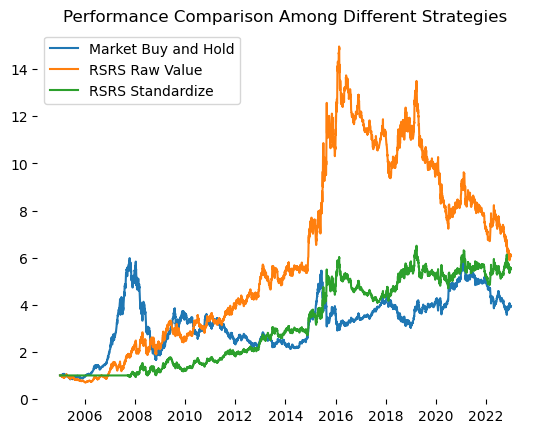

In [179]:
# Set the title for the plot to indicate performance comparison
plt.title("Performance Comparison Among Different Strategies")

# Plot the cumulative return for the market buy-and-hold strategy
plt.plot(Market['Cumulative_Return'], label="Market Buy and Hold")

# Plot the cumulative return for the RSRS strategy using raw values
plt.plot(np.cumprod(RSRS_Strategy['Strategy_Return'] + 1), label="RSRS Raw Value")

# Plot the cumulative return for the RSRS strategy using standardized values
plt.plot(np.cumprod(RSRS_Standardize['Strategy_Return'] + 1), label="RSRS Standardize")

# Remove the spines (borders) around the plot for a cleaner look
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Add a legend to the plot to identify the different strategies
plt.legend()


From the result, we can tell that RSRS raw value performs better than Standardize Score and Market buy and hold, especially durng the Bull market in China during 2015

In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_statistics(cumulative_returns, strategy_signal=None):
    if not isinstance(cumulative_returns, pd.Series):
        cumulative_returns = pd.Series(cumulative_returns)
    # Annualized Return
    annualized_return = cumulative_returns.iloc[-1] ** (252 / len(cumulative_returns)) - 1
    
    # Sharpe Ratio (assumes risk-free rate is 0)
    daily_returns = cumulative_returns.pct_change().dropna()
    
        # Annual Risk 
    Annual_Risk =  daily_returns.std() * np.sqrt(252)
    
    sharpe_ratio = annualized_return / Annual_Risk
    
    # Max Drawdown
    max_drawdown = ((cumulative_returns / cumulative_returns.cummax()) - 1).min()
    
    # Total Days
    total_days = len(cumulative_returns)
    
    # Number of Trades (assuming trade occurs when sign of return changes)
    trades = (daily_returns!= 0).sum()
    
    # Average Holding Period
    avg_holding_period = total_days / trades
    
    # Winning and Losing Days
    winning_days = (daily_returns > 0).sum()
    losing_days = (daily_returns < 0).sum()
    
    # Win Rate
    win_rate = winning_days / total_days
    
    # Average Winning and Losing Returns
    avg_winning_return = daily_returns[daily_returns > 0].mean()
    avg_losing_return = daily_returns[daily_returns < 0].mean()
    
    # Profit-Loss Ratio
    profit_loss_ratio = avg_winning_return / abs(avg_losing_return)
    
    # Number of Winning and Losing Streaks
 
    # Largest Win and Loss
    largest_win = daily_returns.max()
    largest_loss = daily_returns.min()
    
    # Win Rate (Trades)
    win_rate_trades = (daily_returns > 0).sum() / trades
    
    # Average Win and Loss per Trade
    avg_win_trade = daily_returns[daily_returns > 0].mean()
    avg_loss_trade = daily_returns[daily_returns < 0].mean()
    
    # Profit-Loss Ratio (Trades)
    profit_loss_ratio_trades = avg_win_trade / abs(avg_loss_trade)
    
    if strategy_signal is not None:
        trades = (np.sign(strategy_signal).diff() != 0).sum()
    else:
        trades = None
    
    # Average Holding Period
    if trades:
        avg_holding_period = total_days / trades
    else:
        avg_holding_period = None
    
    
    
    return {
        "Annualized Return": annualized_return,
        "Annual Risk": Annual_Risk,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Total Days": total_days,
        "Number of Trades": trades,
        "Average Holding Period": avg_holding_period,
        "Winning Days": winning_days,
        "Losing Days": losing_days,
        "Win Rate": win_rate,
        "Avg Winning Return": avg_winning_return,
        "Avg Losing Return": avg_losing_return,
        "Profit-Loss Ratio": profit_loss_ratio,
        "Largest Win": largest_win,
        "Largest Loss": largest_loss,
        "Win Rate (Trades)": win_rate_trades,
        "Avg Win per Trade": avg_win_trade,
        "Avg Loss per Trade": avg_loss_trade,
        "Profit-Loss Ratio (Trades)": profit_loss_ratio_trades
    }

# Flexible function to create the table
def create_statistics_table(*datasets, labels):
    # Calculate statistics for each dataset
    stats_list = [calculate_statistics(dataset[0], dataset[1]) for dataset in datasets]
    
    # Create the DataFrame structure
    data = {
        'Statistics': [
            "Annualized Return", "Annual Risk", "Sharpe Ratio", "Max Drawdown", "Total Days", "Number of Trades", 
            "Average Holding Period", "Winning Days", "Losing Days", 
            "Average Winning Return (Daily)", "Average Losing Return (Daily)", "Profit-Loss Ratio (Daily)", 
            "Largest Single Win", "Largest Single Loss", 
            "Win Rate (Trades)", "Average Winning Return (Per Trade)", "Average Losing Return (Per Trade)", 
            "Profit-Loss Ratio (Per Trade)"
        ]
    }
    
    # Add statistics for each dataset
    for label, stats in zip(labels, stats_list):
        data[label] = [
            f"{stats['Annualized Return']:.2%}", f"{stats['Annual Risk']:.2%}",
            f"{stats['Sharpe Ratio']:.2f}", 
            f"{stats['Max Drawdown']:.2%}", f"{stats['Total Days']}", 
            f"{stats['Number of Trades']}" if stats['Number of Trades'] is not None else "N/A", 
            f"{stats['Average Holding Period']:.2f}" if stats['Average Holding Period'] is not None else "N/A", 
            f"{stats['Winning Days']}", f"{stats['Losing Days']}", 
            f"{stats['Avg Winning Return']:.2%}", 
            f"{stats['Avg Losing Return']:.2%}", f"{stats['Profit-Loss Ratio']:.2f}", 
            f"{stats['Largest Win']:.2%}", f"{stats['Largest Loss']:.2%}", 
            f"{stats['Win Rate (Trades)']:.2%}" if stats['Win Rate (Trades)'] is not None else "N/A", 
            f"{stats['Avg Win per Trade']:.2%}", 
            f"{stats['Avg Loss per Trade']:.2%}", f"{stats['Profit-Loss Ratio (Trades)']:.2f}" if stats['Profit-Loss Ratio (Trades)'] is not None else "N/A"
        ]
    
    df = pd.DataFrame(data)
    
    # Plot the table
    fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the size as needed
    ax.axis('tight')
    ax.axis('off')
    
    # Create the table
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    
    # Set table style
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 1.5)  # Adjust the scaling as needed
    
    # Set custom colors for the header and cells
    header_color = '#730072'
    row_colors = ['#ece4f0', '#d4c5de']  # Alternating row colors
    
    # Set header color and remove grid lines
    for (i, j), cell in table.get_celld().items():
        cell.set_linewidth(0)  # Remove the grid lines inside the table
        if i == 0:  # Header row
            cell.set_fontsize(12)
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor(header_color)
        else:  # Data rows
            cell.set_facecolor(row_colors[i % len(row_colors)])  # Alternate row colors
    
    # Adjust the table appearance
    table.auto_set_column_width([0] + list(range(1, len(labels) + 1)))  # Adjust column widths
    
    plt.show()

# Example usage:
#create_statistics_table((cumulative_returns1, strategy_signal1), (cumulative_returns2, strategy_signal2), labels=["Market", "RSRS"])


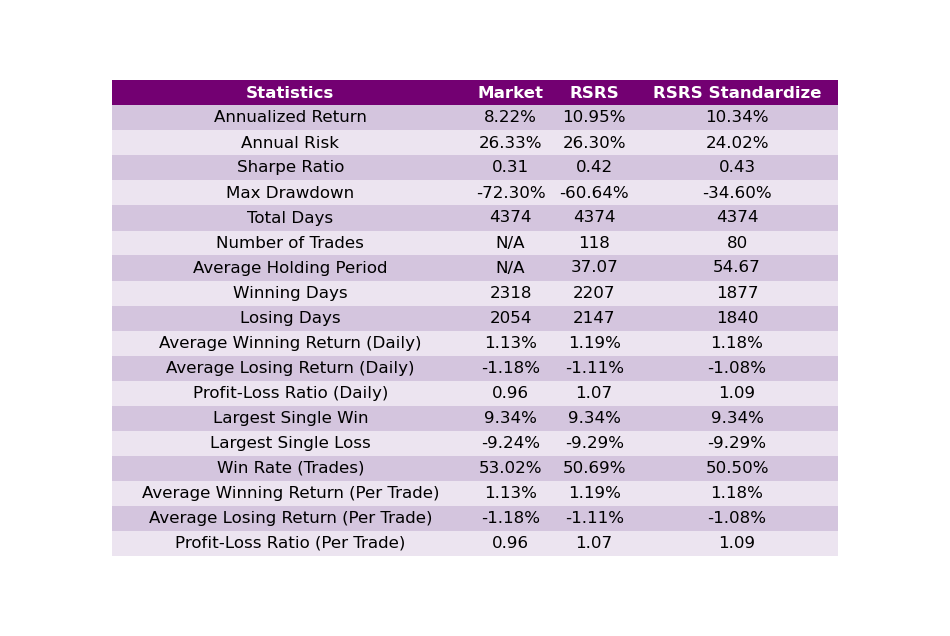

In [181]:
create_statistics_table( (Market['Cumulative_Return'],None),
                         (RSRS_Strategy['Strategy_Cumulative_Return'], RSRS_Strategy['Strategy_Signal']),
                         (np.cumprod(RSRS_Standardize['Strategy_Return']+1),RSRS_Standardize['Strategy_Signal'])
                        ,labels=["Market",'RSRS','RSRS Standardize'])

### Summary 

The analysis of the strategy performance in relation to the market reveals that both the RSRS and RSRS Standardize strategies provide superior risk-adjusted returns compared to a simple market buy-and-hold approach. The RSRS strategy achieves a higher annualized return (9.30%) than the market (7.15%), although this comes with a slightly higher annual risk that is comparable to the market's (25.61% vs. 25.64%). The RSRS Standardize strategy, while having a slightly lower annualized return (8.32%), exhibits significantly lower risk (23.44%) and a much smaller maximum drawdown (-34.60%) compared to the market's substantial drawdown (-72.30%). This suggests that the RSRS Standardize strategy is more robust during periods of market downturns. Both strategies demonstrate better risk-adjusted performance, as indicated by their higher Sharpe Ratios, with the RSRS strategy at 0.48 and RSRS Standardize at 0.46, compared to the market’s 0.40. The RSRS strategy's higher trading frequency (124 trades) and the RSRS Standardize's more conservative approach (84 trades) suggest different levels of market engagement, with RSRS being more aggressive and RSRS Standardize focusing on more stable, less frequent trades. Both strategies also exhibit a higher profit-loss ratio per trade compared to the market, indicating more effective management of winning and losing trades. In conclusion, both RSRS strategies outperform the market, with RSRS Standardize being particularly well-suited for investors looking for a balance between return and risk, especially during volatile market conditions.

## 3. Analysis of the indicator and Optimization for the strategy 

### 3.1 Test the result for different N for RSRS and see if we can do better than the performance with 20 days in all of the metrics

In [182]:
# Define function to compute RSRS beta and R-squared values for multiple observation window sizes
def RSRS_Signal(Dataset, Number_Observation, Length):
    
    # Loop through each observation window size specified in Number_Observation
    for j in Number_Observation:
        # Initialize arrays to store beta coefficients and R-squared values, filled with NaN
        beta = np.full(Dataset.shape[0], np.nan)
        r_squared = np.full(Dataset.shape[0], np.nan)
        
        # Loop through the dataset using the current observation window size
        for i in range(j, Length + 1):
            # Select 'high' prices as dependent variable (y) for the past 'j' days
            y = Dataset['high'].iloc[i - j:i].values
            
            # Select 'low' prices as independent variable (X) and add column of ones for intercept
            X = np.c_[np.ones(j), Dataset['low'].iloc[i-j:i].values]

            # Create and fit a linear regression model
            model = LinearRegression()
            model.fit(X, y)

            # Store the slope (beta coefficient) and R-squared value of the fitted model
            beta[i - 1] = model.coef_[1]
            r_squared[i - 1] = model.score(X, y)

        # Add the computed beta coefficients and R-squared values as new columns to the dataset
        Dataset[f'{j}rsrs_beta'] = beta
        Dataset[f'{j}r_squared'] = r_squared

In [183]:
# Test N from 14 to 20 
Market_Test = Market.copy()
RSRS_Signal(Market_Test,np.arange(14,21), len(Market_Test))
Market_Test

,open,high,low,close,volume,Daily_Return,Cumulative_Return,rsrs_beta,r_squared,rsrs_zscore,...,16rsrs_beta,16r_squared,17rsrs_beta,17r_squared,18rsrs_beta,18r_squared,19rsrs_beta,19r_squared,20rsrs_beta,20r_squared
date,,,,,,,,,,,,,,,,,,,,,
2005-01-04,994.769,994.769,980.658,982.794,741286894,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,981.577,997.323,979.877,992.564,711910898,0.009941,1.009941,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-06,993.331,993.788,980.330,983.174,628802905,-0.009460,1.000387,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-07,983.045,995.711,979.812,983.958,729869409,0.000797,1.001184,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-10,983.760,993.959,979.789,993.879,579169799,0.010083,1.011279,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,3830.568,3856.807,3827.519,3843.489,7300571200,0.003989,3.910778,0.890240,0.892293,-0.095173,...,0.931600,0.896571,0.940414,0.895164,0.940584,0.894717,0.957321,0.900131,0.890240,0.892293
2022-12-27,3860.905,3891.850,3856.580,3887.854,7751535000,0.011543,3.955920,0.964048,0.901101,0.495944,...,0.941160,0.897580,0.941473,0.897754,0.948902,0.896514,0.949314,0.896024,0.964048,0.901101
2022-12-28,3874.913,3884.721,3854.941,3871.264,8442465600,-0.004267,3.939039,0.960882,0.895619,0.473518,...,0.936551,0.901714,0.953491,0.896846,0.954067,0.897084,0.960187,0.896171,0.960882,0.895619


In [184]:
Market_Test

,open,high,low,close,volume,Daily_Return,Cumulative_Return,rsrs_beta,r_squared,rsrs_zscore,...,16rsrs_beta,16r_squared,17rsrs_beta,17r_squared,18rsrs_beta,18r_squared,19rsrs_beta,19r_squared,20rsrs_beta,20r_squared
date,,,,,,,,,,,,,,,,,,,,,
2005-01-04,994.769,994.769,980.658,982.794,741286894,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,981.577,997.323,979.877,992.564,711910898,0.009941,1.009941,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-06,993.331,993.788,980.330,983.174,628802905,-0.009460,1.000387,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-07,983.045,995.711,979.812,983.958,729869409,0.000797,1.001184,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-10,983.760,993.959,979.789,993.879,579169799,0.010083,1.011279,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,3830.568,3856.807,3827.519,3843.489,7300571200,0.003989,3.910778,0.890240,0.892293,-0.095173,...,0.931600,0.896571,0.940414,0.895164,0.940584,0.894717,0.957321,0.900131,0.890240,0.892293
2022-12-27,3860.905,3891.850,3856.580,3887.854,7751535000,0.011543,3.955920,0.964048,0.901101,0.495944,...,0.941160,0.897580,0.941473,0.897754,0.948902,0.896514,0.949314,0.896024,0.964048,0.901101
2022-12-28,3874.913,3884.721,3854.941,3871.264,8442465600,-0.004267,3.939039,0.960882,0.895619,0.473518,...,0.936551,0.901714,0.953491,0.896846,0.954067,0.897084,0.960187,0.896171,0.960882,0.895619


In [185]:
def Compute_Strategy_Return(DF, Number_Observation):     
    def calculate_signal(beta):
        if beta > 1:
            return 1
        if beta < 0.8:
            return -1 
    # Compuet return for different day of N 
    for i in Number_Observation:
        DF[f'{i}_days_Strategy_Signal'] = DF[f'{i}rsrs_beta'].shift(1).apply(calculate_signal)
        DF[f'{i}_days_Strategy_Signal'] = DF[f'{i}_days_Strategy_Signal'].fillna(method= 'ffill')
        DF[f'{i}_days_Strategy_Signal'] = DF[f'{i}_days_Strategy_Signal'].fillna(0)
        DF[f'{i}_days_Strategy_Return'] = DF[f'{i}_days_Strategy_Signal'] * DF['Daily_Return']
        DF[f'RSRS_{i}_days_Cumulative_Return'] = np.cumprod(DF[f'{i}_days_Strategy_Return'] + 1)
Compute_Strategy_Return(Market_Test,np.arange(14,21))

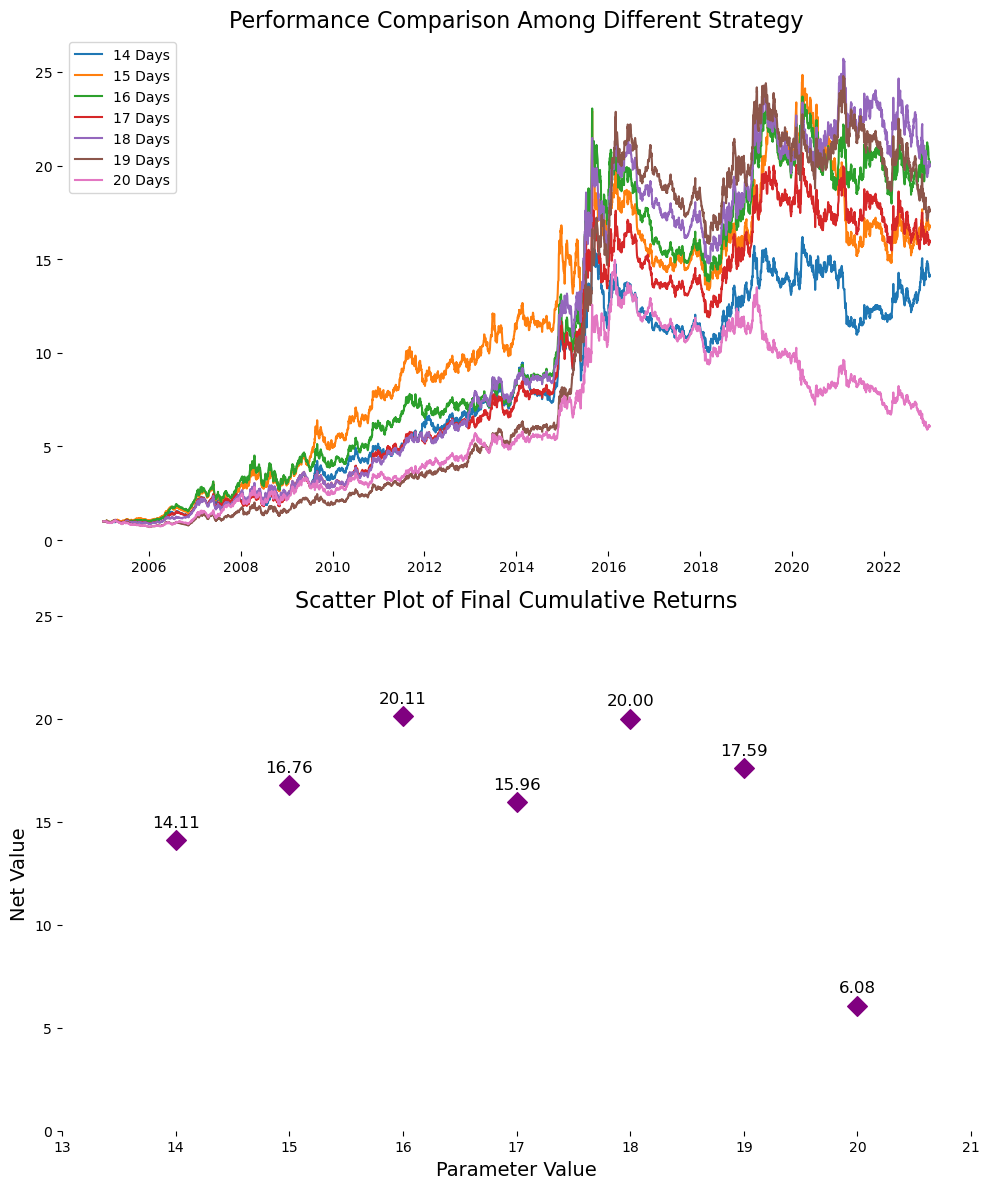

In [186]:

# Create a figure and two subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize=(10, 12))  # Adjust the figure size as needed

# First plot (line plot)
for i in np.arange(14, 21):
    ax[0].plot(Market_Test[f'RSRS_{i}_days_Cumulative_Return'], label=f"{i} Days")

ax[0].set_title("Performance Comparison Among Different Strategy", fontsize=16)
ax[0].legend()
for spine in ax[0].spines.values():
    spine.set_visible(False)

# Second plot (scatter plot)
A = []
for i in np.arange(14, 21):
    A.append(f'RSRS_{i}_days_Cumulative_Return')
values = Market_Test.iloc[-1][A].values

ax[1].scatter(np.arange(14, 21), values, color='purple', marker='D', s=100)

# Annotate each point with its value, moving the text slightly upward
for i, value in enumerate(values):
    ax[1].text(14 + i, value + 0.5, f'{value:.2f}', fontsize=12, ha='center', va='bottom')

ax[1].set_xlim(13, 21)
ax[1].set_ylim(0, 25)
ax[1].set_title("Scatter Plot of Final Cumulative Returns", fontsize=16)
ax[1].set_xlabel("Parameter Value", fontsize=14)
ax[1].set_ylabel("Net Value", fontsize=14)
for spine in ax[1].spines.values():
    spine.set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the combined plot
plt.show()


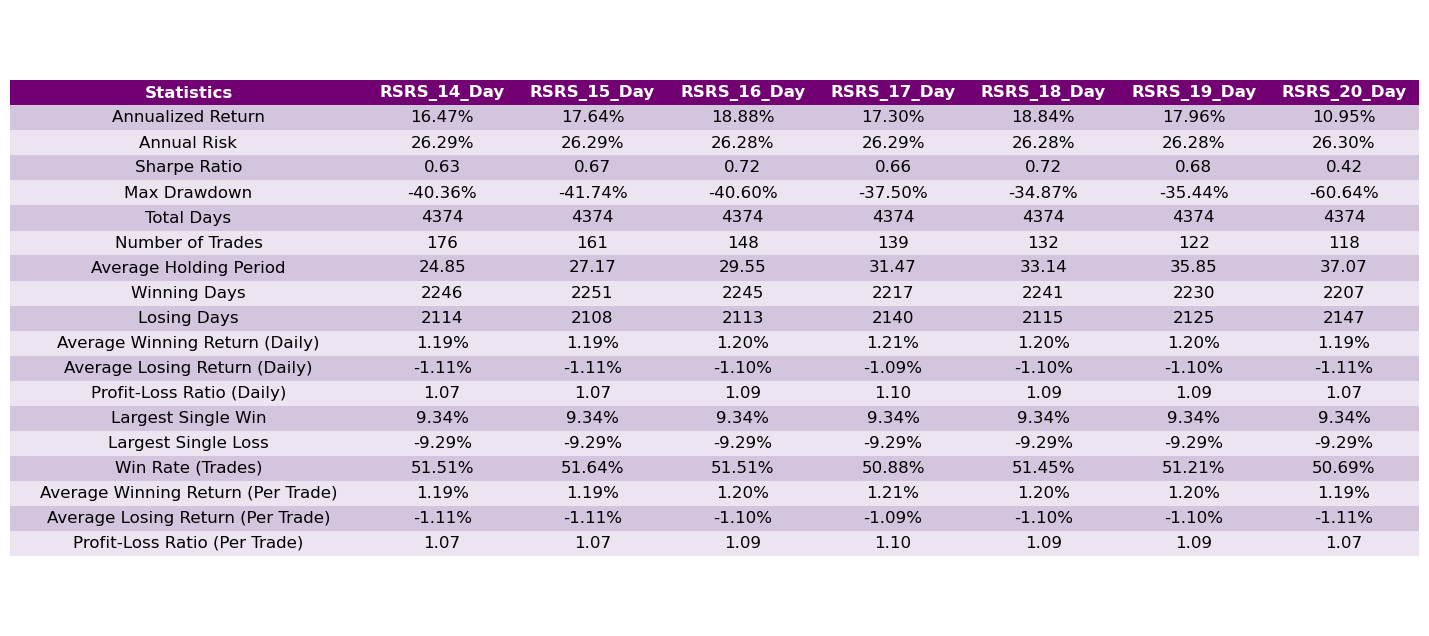

In [187]:
create_statistics_table((Market_Test['RSRS_14_days_Cumulative_Return'],Market_Test['14_days_Strategy_Signal']),
(Market_Test['RSRS_15_days_Cumulative_Return'],Market_Test['15_days_Strategy_Signal']),
(Market_Test['RSRS_16_days_Cumulative_Return'],Market_Test['16_days_Strategy_Signal']),
(Market_Test['RSRS_17_days_Cumulative_Return'],Market_Test['17_days_Strategy_Signal']),
(Market_Test['RSRS_18_days_Cumulative_Return'],Market_Test['18_days_Strategy_Signal']),
(Market_Test['RSRS_19_days_Cumulative_Return'],Market_Test['19_days_Strategy_Signal']),
(Market_Test['RSRS_20_days_Cumulative_Return'],Market_Test['20_days_Strategy_Signal']),labels = [f"RSRS_{i}_Day" for i in range(14,21)])

The performance of the RSRS strategy using different 
𝑁 days for computing the beta shows varying results, particularly in terms of annualized return and risk. Strategies using shorter 
𝑁 days (14 to 18) generally perform better, with annualized returns peaking at 17.43% for the 16-day period. These shorter 
𝑁 day strategies also maintain a higher Profit-Loss Ratio and a better balance between winning and losing days. However, as 
𝑁 increases beyond 19 days, the strategy's performance begins to deteriorate significantly, with the 20-day strategy showing a sharp decline in performance. This suggests that while the RSRS strategy can be effective with shorter observation periods, extending the period too far diminishes its effectiveness, likely due to the strategy becoming less responsive to market changes. Comparing this to the earlier results, where the RSRS Standardize strategy also showed lower returns and a lower Sharpe Ratio, it becomes clear that finding an optimal 
𝑁 is critical for maximizing the effectiveness of the RSRS strategy.

<Axes: >

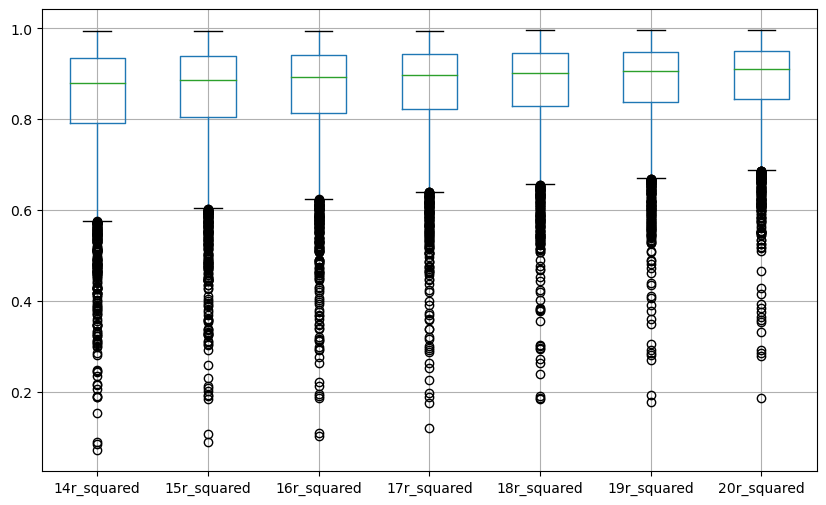

In [188]:

Column_Name = []
for i in range(14,21):
    Column_Name.append(f'{i}r_squared')
Column_Name
plt.figure(figsize = (10,6))
Market_Test[Column_Name].boxplot(column=Column_Name)

### 3.2 Now let's see if we can improve the performance of the strategy just by adjusting the Standardize RSRS Score

Here we will adjust the RSRS standardize based on the 𝑅^2. We want to eliminate the false signals by using R^2. The process of standardization involves adjusting the RSRS scores based on additional quantitative factors, such as the 
𝑅^2
  value, which is a measure of how well the data fits a linear regression model. The 
𝑅^2  value ranges between 0 and 1, where 1 indicates a perfect fit. 

If we simply multiply the 
𝑅^2
  value with the RSRS raw value, the adjustment might not correctly reflect the quality of the trend signal. The idea is that the 
𝑅^2
  value should modify the RSRS raw value in a way that accounts for the strength and reliability of the trend, but direct multiplication may only amplify or diminish the RSRS value without properly penalizing weaker signals.

Instead, we should use the 
𝑅
^2
  value in combination with the RSRS standardized value because the standardization process already accounts for the distribution of RSRS values over time. This approach ensures that the penalty (or adjustment) is applied in a more meaningful way, better reflecting the confidence in the trend.

In [189]:
RSRS_Standardize_Adjust = Market.copy()
RSRS_Standardize_Adjust['Adjusted_RSRS_Standardize'] = RSRS_Standardize_Adjust['rsrs_zscore'] * RSRS_Standardize_Adjust['r_squared']
def Compute_Standardize_Return(DF):     
    def calculate_signal(beta):
        if beta > 1:
            return 1
        if beta < -1:
            return -1 
    DF['Strategy_Signal'] = DF['Adjusted_RSRS_Standardize'].shift(1).apply(calculate_signal)
    DF['Strategy_Signal'] = DF['Strategy_Signal'].fillna(method= 'ffill')
    DF['Strategy_Signal'] = DF['Strategy_Signal'].fillna(0)
    DF['Strategy_Return'] = DF['Strategy_Signal'] * DF['Daily_Return']
    
Compute_Standardize_Return(RSRS_Standardize_Adjust)

Let's test if the performance of the RSRS_Standardize has improved

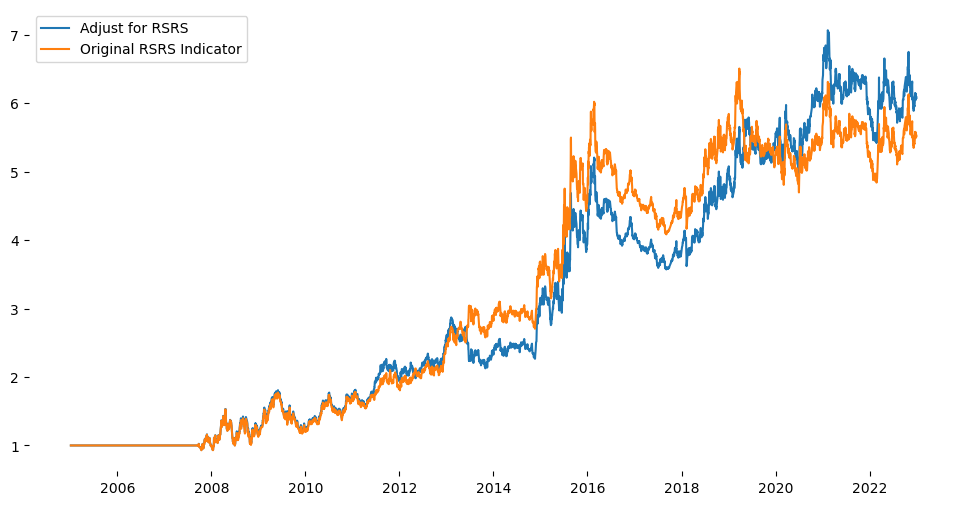

In [190]:
plt.figure(figsize = (12,6))
plt.plot(np.cumprod(1 + RSRS_Standardize_Adjust['Strategy_Return']),label="Adjust for RSRS")
plt.plot(np.cumprod(RSRS_Standardize['Strategy_Return']+1), label = "Original RSRS Indicator")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.legend()

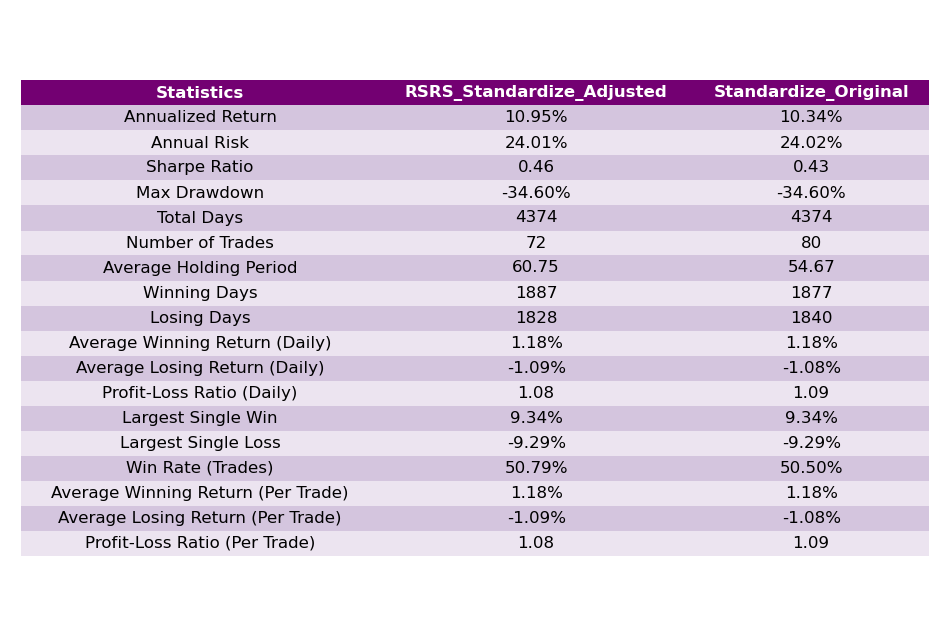

In [191]:
create_statistics_table(
                         (np.cumprod(1 + RSRS_Standardize_Adjust['Strategy_Return']), RSRS_Standardize_Adjust['Strategy_Signal']),
                         (np.cumprod(RSRS_Standardize['Strategy_Return']+1),RSRS_Standardize['Strategy_Signal'])
                        ,labels=['RSRS_Standardize_Adjusted','Standardize_Original'])

As we can see, the strategy allows us to have less trades, potentially decrease number of false signals and further improve  the performance 

### 3.2.1: Analysis of RSRS Adjusted Indicator

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


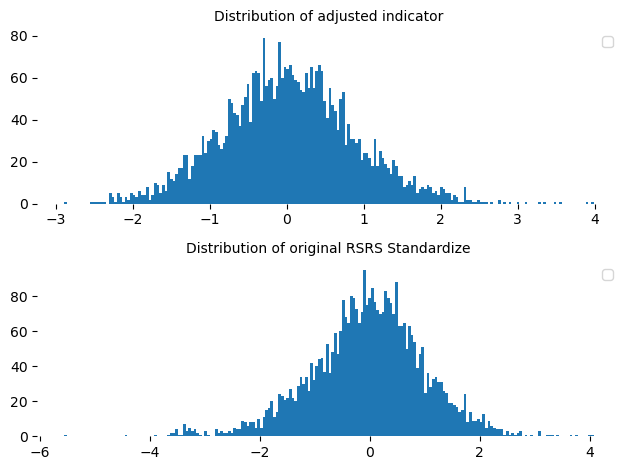

In [192]:
fig , axs = plt.subplots(2,1)

axs[0].hist(RSRS_Standardize_Adjust['Adjusted_RSRS_Standardize'] ,bins = 200 )
axs[0].set_title("Distribution of adjusted indicator", fontsize=10)
axs[0].legend()
for spine in axs[0].spines.values():
    spine.set_visible(False)
axs[1].hist(RSRS_Standardize['rsrs_zscore'] ,bins = 200)
axs[1].set_title("Distribution of original RSRS Standardize", fontsize=10)
axs[1].legend()
for spine in axs[1].spines.values():
    spine.set_visible(False)

plt.tight_layout()

From the distribution of the indicators, it is obvious that why the adjusted indicator gives us a better performance. This is because it effectively removes the false signal that prevents us from experiencing a great loss. We can tell the adjusted indicator follows more a normla distribution than before. That makes it more logical to use distribution wise strategy to trade

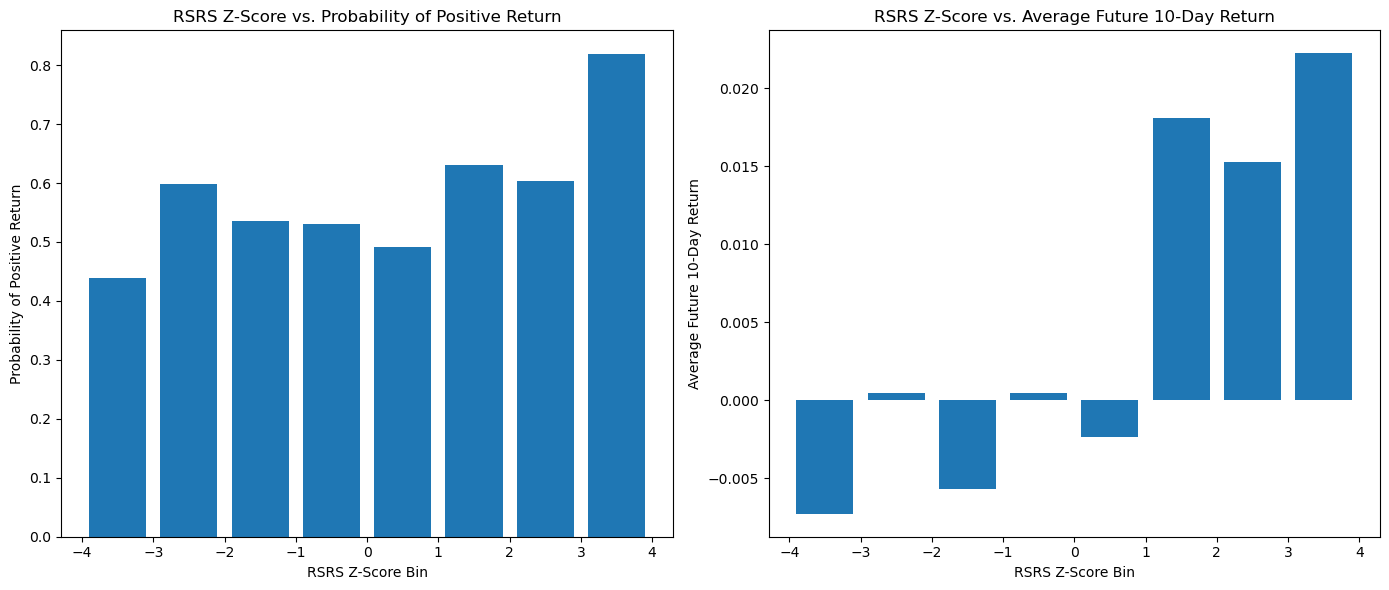

In [193]:
df = RSRS_Standardize_Adjust.copy()
df['Future_10_days_Return'] = df['close'].shift(-10) / df['close'] - 1
df = df.dropna(subset = ['Future_10_days_Return'])

bins = [-float('inf'), -3, -2, -1, 0, 1, 2, 3, float('inf')]
labels = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]

df['RSRS_Bins'] = pd.cut(df['rsrs_zscore'], bins=bins, labels=labels)

grouped = df.groupby("RSRS_Bins")

mean_return = grouped['Future_10_days_Return'].mean()
prob_positive_return = grouped.apply(lambda x: (x['Future_10_days_Return'] > 0).mean())

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.bar(mean_return.index.astype(float), prob_positive_return)
plt.title('RSRS Z-Score vs. Probability of Positive Return')
plt.xlabel('RSRS Z-Score Bin')
plt.ylabel('Probability of Positive Return')

# Plot the average future returns
plt.subplot(1, 2, 2)
plt.bar(mean_return.index.astype(float), mean_return)
plt.title('RSRS Z-Score vs. Average Future 10-Day Return')
plt.xlabel('RSRS Z-Score Bin')
plt.ylabel('Average Future 10-Day Return')

plt.tight_layout()
plt.show()

From the graph above, it is very obvious that RSRS standardize indicator is effective in predicting return when indicator is positive. We can see that the 10-days return when the indicator is positive s usally positive. This is usually not the case for negative as we don't see a strong correlation with negative Z-score and negative return. The Z-score is particularly useful in predticing buil market from graph 1

###### Let's see how the adjusted RSRS standardize indicator performs relative with 10 days return 

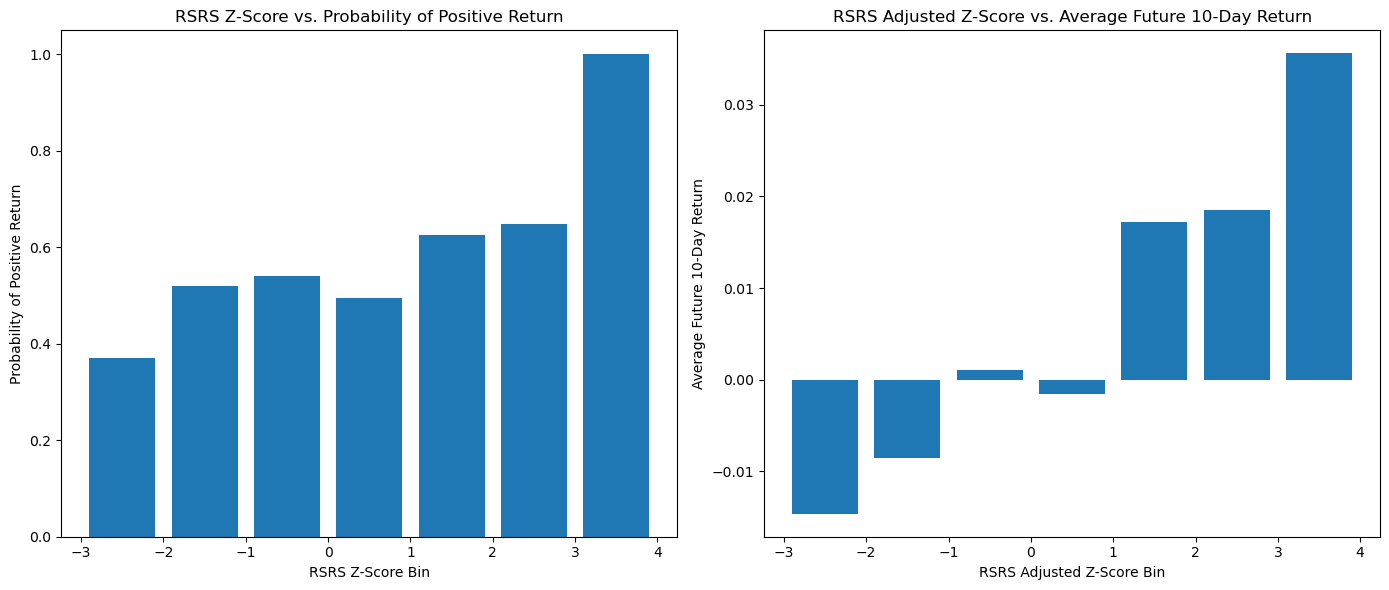

In [194]:
df = RSRS_Standardize_Adjust.copy()
df['Future_10_days_Return'] = df['close'].shift(-10) / df['close'] - 1
df = df.dropna(subset = ['Future_10_days_Return'])

bins = [-float('inf'), -3, -2, -1, 0, 1, 2, 3, float('inf')]
labels = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]

# The key difference is we use different indicators now 
df['RSRS_Bins'] = pd.cut(df['Adjusted_RSRS_Standardize'], bins=bins, labels=labels)

grouped = df.groupby("RSRS_Bins")

mean_return = grouped['Future_10_days_Return'].mean()
prob_positive_return = grouped.apply(lambda x: (x['Future_10_days_Return'] > 0).mean())

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.bar(mean_return.index.astype(float), prob_positive_return)
plt.title('RSRS Z-Score vs. Probability of Positive Return')
plt.xlabel('RSRS Z-Score Bin')
plt.ylabel('Probability of Positive Return')

# Plot the average future returns
plt.subplot(1, 2, 2)
plt.bar(mean_return.index.astype(float), mean_return)
plt.title('RSRS Adjusted Z-Score vs. Average Future 10-Day Return')
plt.xlabel('RSRS Adjusted Z-Score Bin')
plt.ylabel('Average Future 10-Day Return')

plt.tight_layout()
plt.show()

The graph above shows that, after adjusting the RSRS standardize, the positive scores even gives me stronger predicting power for bull market.

## 4. Multi-Factor Strategy: We use more than one factor to build a new strategy 

### 4.1 First strategy: RSRS Standardize and Moving average. This strtegy allows us to confirm buy and sell signal before we execute orders

# Trading Strategy Summary

- **Indicators and Setup:**
  - Calculate RSRS Z-score for momentum.
  - Compute 20-day moving average (MA20).
  - Track moving average values 1 and 3 days prior (`MA20_PREV_1`, `MA20_PREV_3`).

- **Buy Signal:**
  - Buy when RSRS Z-score > 1.
  - `MA20_PREV_1` > `MA20_PREV_3`.

- **Short Sell Signal:**
  - Short sell when RSRS Z-score < -1.
  - `MA20_PREV_1` < `MA20_PREV_3`.

- **Exit Long Position:**
  - RSRS Z-score ≤ 1 while holding long.

- **Exit Short Position:**
  - RSRS Z-score ≥ -1 while holding short.

- **Returns Calculation:**
  - Daily strategy returns: based on signals and daily market returns.
  - Cumulative strategy returns: product of daily returns over time.

In [195]:
Market
New_Strategy = Market.copy()
New_Strategy['MA20'] =  New_Strategy['close'].rolling(20).mean()
New_Strategy['MA20_PREV_1'] = New_Strategy['MA20'].shift(1)
New_Strategy['MA20_PREV_3'] = New_Strategy['MA20'].shift(3)


In [196]:

New_Strategy['Strategy_Signal'] = np.nan

# Buy Signal: rsrs_zscore > 1 and MA20 condition
New_Strategy.loc[
    ( New_Strategy['rsrs_zscore'] > 1) & ( New_Strategy['MA20_PREV_1'] >  New_Strategy['MA20_PREV_3']),
    'Strategy_Signal'
] = 1

# Short Signal: rsrs_zscore < -1 and MA20 condition
New_Strategy.loc[
    ( New_Strategy['rsrs_zscore'] < -1) & ( New_Strategy['MA20_PREV_1'] <  New_Strategy['MA20_PREV_3']),
    'Strategy_Signal'
] = -1

# End Long Signal: rsrs_zscore <= 1 while holding long position
New_Strategy.loc[
    ( New_Strategy['rsrs_zscore']  <= -1) & ( New_Strategy['Strategy_Signal'].shift(1) == 1),
    'Strategy_Signal'
] = 0

# End Short Signal: rsrs_zscore >= -1 while holding short position
New_Strategy.loc[
    ( New_Strategy['rsrs_zscore'] > -1) & ( New_Strategy['Strategy_Signal'].shift(1) == -1),
    'Strategy_Signal'
] = 0

New_Strategy = New_Strategy.fillna(method= 'ffill')
# # Calculate Daily Strategy Returns based on the adjusted signals

New_Strategy['Strategy_Return'] =  New_Strategy['Strategy_Signal'].shift(1) *  New_Strategy['Daily_Return']

# # Calculate Cumulative Strategy Return

New_Strategy['Cumulative_Strategy_Return'] = (1 +  New_Strategy['Strategy_Return']).cumprod()




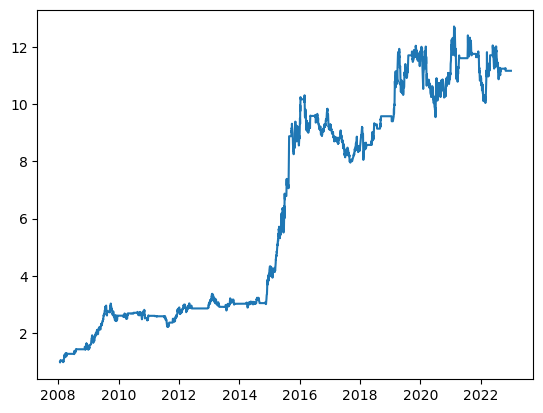

In [197]:
plt.plot(New_Strategy['Cumulative_Strategy_Return'])

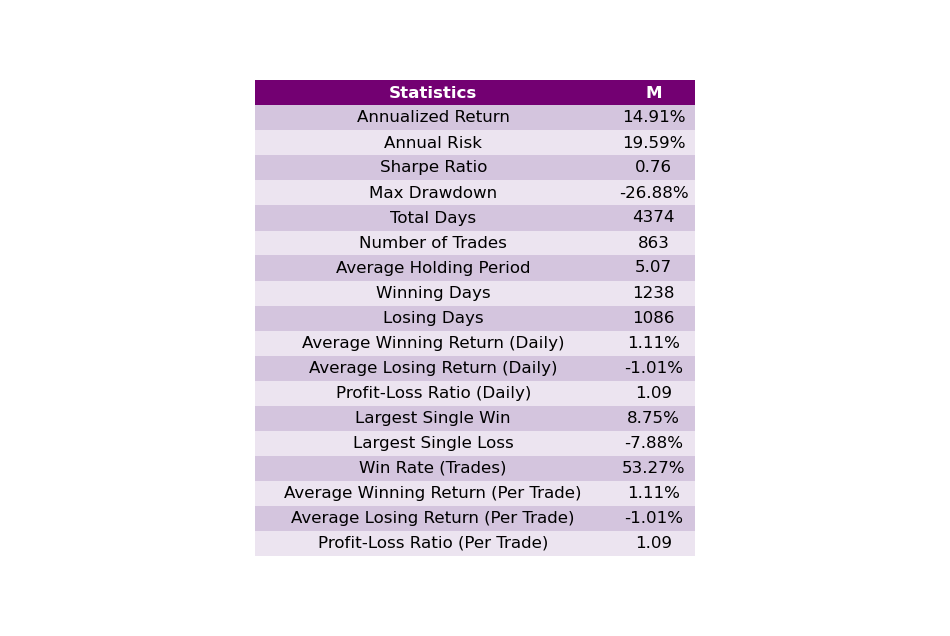

In [198]:
create_statistics_table(
(New_Strategy['Cumulative_Strategy_Return'],New_Strategy['Strategy_Signal']),
    labels = "MA_RSRS_Standardize"
)

This strategy allows us to to decrease the volatility and decrease the max drawdown 

### 4.2 Volumen and RSRS Based Strategy 

# Volume-Based Trading Strategy Summary

- **Indicators and Setup:**
  - Calculate RSRS Z-score for momentum.
  - Compute rolling correlation between volume and RSRS Z-score over a 10-day window.
  - Set a threshold for correlation at 0.5 for signal validation.

- **Buy Signal:**
  - Buy when RSRS Z-score > 1.
  - Rolling correlation > 0.5.

- **Short Sell Signal:**
  - Short sell when RSRS Z-score < -1.
  - Rolling correlation > 0.5.

- **Exit Long Position:**
  - RSRS Z-score ≤ 1 while holding long.

- **Exit Short Position:**
  - RSRS Z-score ≥ -1 while holding short.

- **Returns Calculation:**
  - Daily strategy returns: based on signals and daily market returns.
  - Cumulative strategy returns: product of daily returns over time.


In [199]:
Volumn_Strategy = Market.copy()
Volumn_Strategy

,open,high,low,close,volume,Daily_Return,Cumulative_Return,rsrs_beta,r_squared,rsrs_zscore
date,,,,,,,,,,
2005-01-04,994.769,994.769,980.658,982.794,741286894,NaN,NaN,NaN,NaN,NaN
2005-01-05,981.577,997.323,979.877,992.564,711910898,0.009941,1.009941,NaN,NaN,NaN
2005-01-06,993.331,993.788,980.330,983.174,628802905,-0.009460,1.000387,NaN,NaN,NaN
2005-01-07,983.045,995.711,979.812,983.958,729869409,0.000797,1.001184,NaN,NaN,NaN
2005-01-10,983.760,993.959,979.789,993.879,579169799,0.010083,1.011279,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-12-26,3830.568,3856.807,3827.519,3843.489,7300571200,0.003989,3.910778,0.890240,0.892293,-0.095173
2022-12-27,3860.905,3891.850,3856.580,3887.854,7751535000,0.011543,3.955920,0.964048,0.901101,0.495944
2022-12-28,3874.913,3884.721,3854.941,3871.264,8442465600,-0.004267,3.939039,0.960882,0.895619,0.473518


In [200]:

Volumn_Strategy['Rolling_Correlaion'] =  Volumn_Strategy['volume'].rolling(window=10).corr(Volumn_Strategy['rsrs_zscore'])

Volumn_Strategy['Strategy_Signal'] = 0

# Buy Signal: rsrs_zscore > 1 and MA20 condition
Volumn_Strategy.loc[
    ( Volumn_Strategy['rsrs_zscore'] > 1) & ( Volumn_Strategy['Rolling_Correlaion'] > 0.5),
    'Strategy_Signal'
] = 1

# Short Signal: rsrs_zscore < -1 and MA20 condition
Volumn_Strategy.loc[
    ( Volumn_Strategy['rsrs_zscore'] < -1) & ( Volumn_Strategy['Rolling_Correlaion'] > 0.5),
    'Strategy_Signal'
] = -1

# End Long Signal: rsrs_zscore <= 1 while holding long position
Volumn_Strategy.loc[
    ( Volumn_Strategy['rsrs_zscore'] <= 1) & ( Volumn_Strategy['Strategy_Signal'].shift(1) == 1),
    'Strategy_Signal'
] = 0

# End Short Signal: rsrs_zscore >= -1 while holding short position
Volumn_Strategy.loc[
    ( Volumn_Strategy['rsrs_zscore'] >= -1) & ( Volumn_Strategy['Strategy_Signal'].shift(1) == -1),
    'Strategy_Signal'
] = 0

# Calculate Daily Strategy Returns based on the adjusted signals
Volumn_Strategy['Strategy_Return'] =  Volumn_Strategy['Strategy_Signal'].shift(1) *  Volumn_Strategy['Daily_Return']

# Calculate Cumulative Strategy Return
Volumn_Strategy['Cumulative_Strategy_Return'] = (1 +  Volumn_Strategy['Strategy_Return']).cumprod()


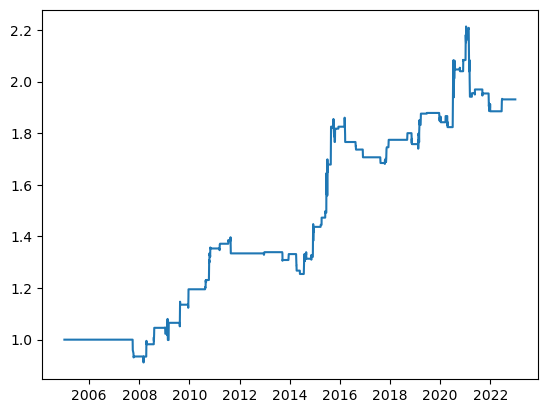

In [201]:
plt.plot(Volumn_Strategy['Cumulative_Strategy_Return'])

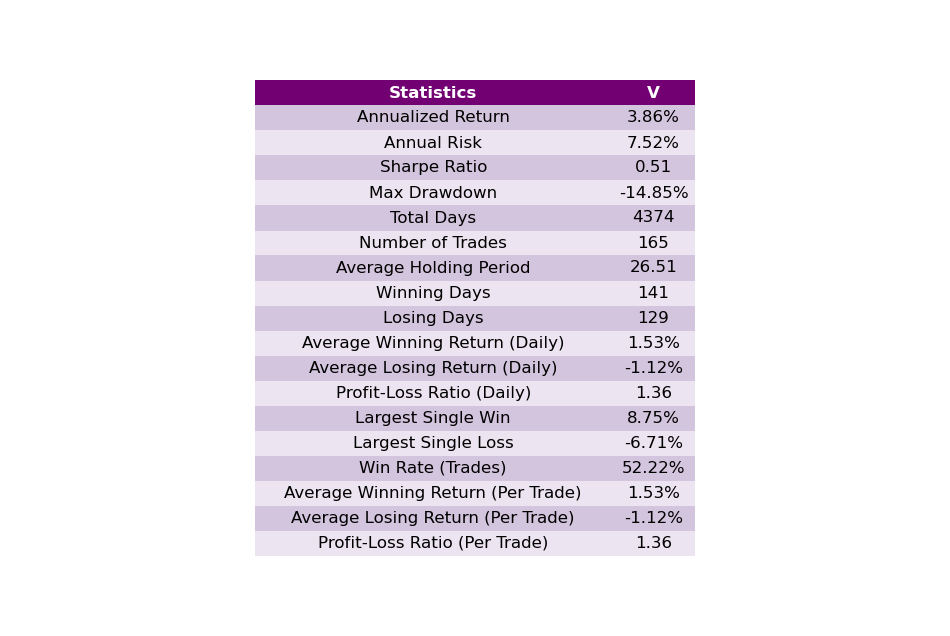

In [202]:
create_statistics_table(
(Volumn_Strategy['Cumulative_Strategy_Return'],Volumn_Strategy['Strategy_Signal']),
    labels = "Volume_RSRS"
)

From the statistical summary, it is obvious that Moving average based is more effective than volume based 

### 4.3 Test on different M parameter on Moving Average Strategy 

In [203]:
import pandas as pd
import numpy as np

def multi_factor_strategy(Market, M_values):
    
    def compute_standardize_RSRS(Data, Window_M):
        # Calculate rolling mean and standard deviation for RSRS Z-Score calculation
        rolling_mean = Data['rsrs_beta'].rolling(window=Window_M).mean()
        rolling_std = Data['rsrs_beta'].rolling(window=Window_M).std()
        Data[f'{Window_M}_rsrs_zscore'] = (Data['rsrs_beta'] - rolling_mean) / rolling_std

    # Calculate moving averages once outside the loop
    Market['MA20'] = Market['close'].rolling(20).mean()
    Market['MA20_PREV_1'] = Market['MA20'].shift(1)
    Market['MA20_PREV_3'] = Market['MA20'].shift(3)

    for M in M_values:
        compute_standardize_RSRS(Market, M)
        Market[f'{M}_Strategy_Signal'] = np.nan

        # Buy Signal
        buy_condition = (Market[f'{M}_rsrs_zscore'] > 1) & (Market['MA20_PREV_1'] > Market['MA20_PREV_3'])
        Market.loc[buy_condition, f'{M}_Strategy_Signal'] = 1

        # Short Signal
        short_condition = (Market[f'{M}_rsrs_zscore'] < -1) & (Market['MA20_PREV_1'] < Market['MA20_PREV_3'])
        Market.loc[short_condition, f'{M}_Strategy_Signal'] = -1

        # End Long Signal
        end_long_condition = (Market[f'{M}_rsrs_zscore'] <= 1) & (Market[f'{M}_Strategy_Signal'].shift(1) == 1)
        Market.loc[end_long_condition, f'{M}_Strategy_Signal'] = 0

        # End Short Signal
        end_short_condition = (Market[f'{M}_rsrs_zscore'] > -1) & (Market[f'{M}_Strategy_Signal'].shift(1) == -1)
        Market.loc[end_short_condition, f'{M}_Strategy_Signal'] = 0

        # Forward fill NaN values to ensure signals persist
        Market[f'{M}_Strategy_Signal'] = Market[f'{M}_Strategy_Signal'].fillna(method= 'ffill')

        # Calculate Daily Strategy Returns based on the adjusted signals
        Market[f'{M}_Strategy_Return'] = Market[f'{M}_Strategy_Signal'].shift(1) * Market['Daily_Return']

        # Calculate Cumulative Strategy Return
        Market[f'{M}_Cumulative_Strategy_Return'] = (1 + Market[f'{M}_Strategy_Return']).cumprod()

    return Market

# Define the M values for the sensitivity analysis
M_values = [450, 500, 550, 600, 650, 700, 750, 800]
# Copy of the Market DataFrame
Multi_Factor = Market.copy()

# Execute the strategy
Multi_Factor = multi_factor_strategy(Multi_Factor, M_values)

# Display the results for the last few rows for checking
Multi_Factor.tail()


,open,high,low,close,volume,Daily_Return,Cumulative_Return,rsrs_beta,r_squared,rsrs_zscore,...,700_Strategy_Return,700_Cumulative_Strategy_Return,750_rsrs_zscore,750_Strategy_Signal,750_Strategy_Return,750_Cumulative_Strategy_Return,800_rsrs_zscore,800_Strategy_Signal,800_Strategy_Return,800_Cumulative_Strategy_Return
date,,,,,,,,,,,,,,,,,,,,,
2022-12-26,3830.568,3856.807,3827.519,3843.489,7300571200,0.003989,3.910778,0.890240,0.892293,-0.095173,...,0.0,8.292213,-0.120972,0.0,0.0,6.443104,-0.145792,0.0,0.0,6.397479
2022-12-27,3860.905,3891.850,3856.580,3887.854,7751535000,0.011543,3.955920,0.964048,0.901101,0.495944,...,0.0,8.292213,0.493022,0.0,0.0,6.443104,0.484399,0.0,0.0,6.397479
2022-12-28,3874.913,3884.721,3854.941,3871.264,8442465600,-0.004267,3.939039,0.960882,0.895619,0.473518,...,-0.0,8.292213,0.466365,0.0,-0.0,6.443104,0.456922,0.0,-0.0,6.397479
2022-12-29,3854.236,3868.293,3838.480,3856.701,7939481500,-0.003762,3.924221,0.974884,0.899118,0.588703,...,-0.0,8.292213,0.582418,0.0,-0.0,6.443104,0.575901,0.0,-0.0,6.397479
2022-12-30,3873.936,3887.553,3868.757,3871.634,7877327200,0.003872,3.939416,0.978624,0.891949,0.621841,...,0.0,8.292213,0.612934,0.0,0.0,6.443104,0.607908,0.0,0.0,6.397479


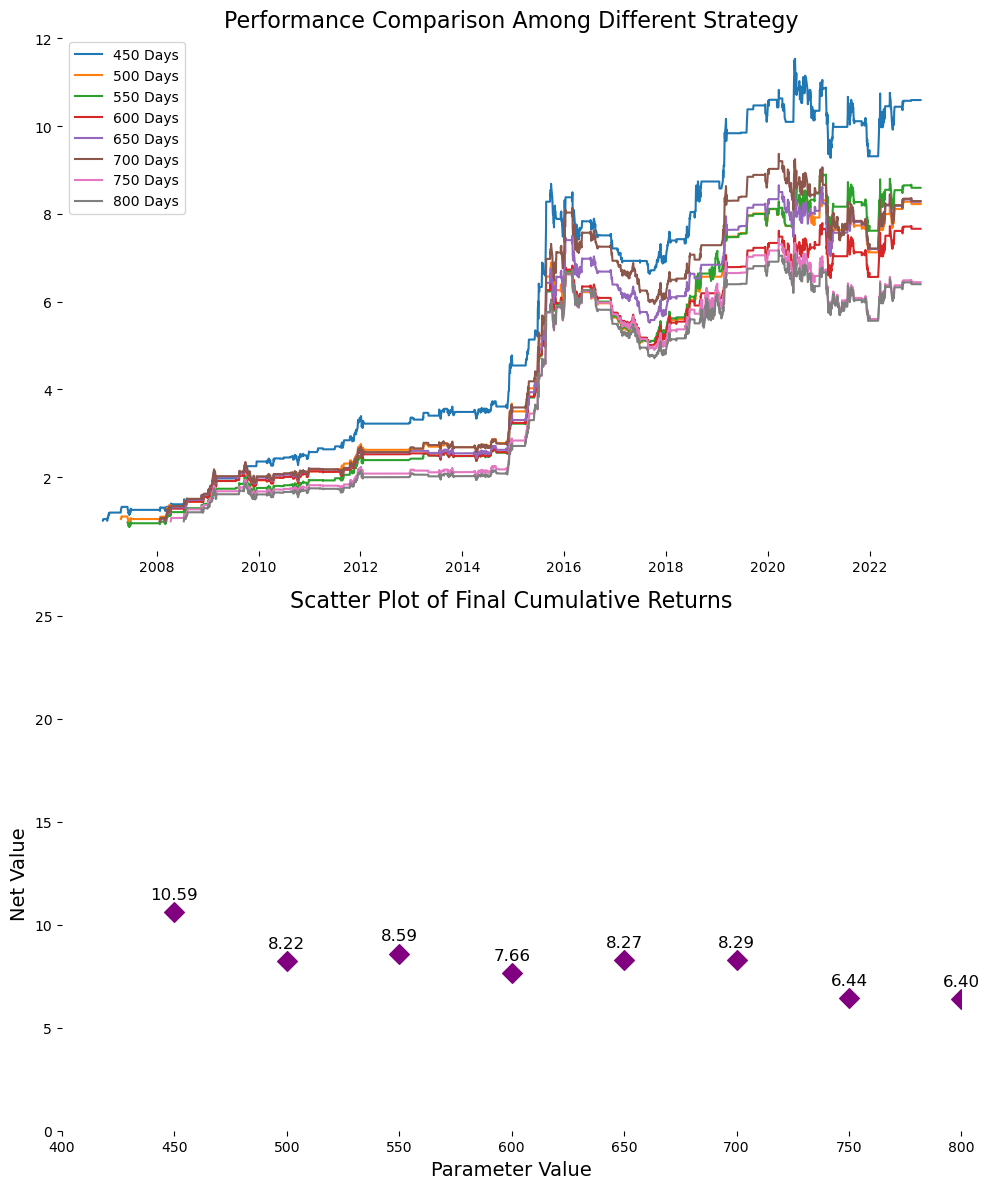

In [204]:

# Create a figure and two subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize=(10, 12))  # Adjust the figure size as needed

# First plot (line plot)
for M in M_values:
    ax[0].plot(Multi_Factor[f'{M}_Cumulative_Strategy_Return'], label=f"{M} Days")

ax[0].set_title("Performance Comparison Among Different Strategy", fontsize=16)
ax[0].legend()
for spine in ax[0].spines.values():
    spine.set_visible(False)

# Second plot (scatter plot)
A = []
for M in M_values:
    A.append(f'{M}_Cumulative_Strategy_Return')
values = Multi_Factor.iloc[-1][A].values

ax[1].scatter(M_values, values, color='purple', marker='D', s=100)

# Annotate each point with its value, moving the text slightly upward
for i, value in enumerate(values):
    ax[1].text(450 + i * 50, value + 0.5, f'{value:.2f}', fontsize=12, ha='center', va='bottom')

ax[1].set_xlim(400, 800)
ax[1].set_ylim(0, 25)
ax[1].set_title("Scatter Plot of Final Cumulative Returns", fontsize=16)
ax[1].set_xlabel("Parameter Value", fontsize=14)
ax[1].set_ylabel("Net Value", fontsize=14)
for spine in ax[1].spines.values():
    spine.set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the combined plot
plt.show()


From the result above, it seems that if we shorten the M parameter,  the performance can get better. Let's see if we can do better

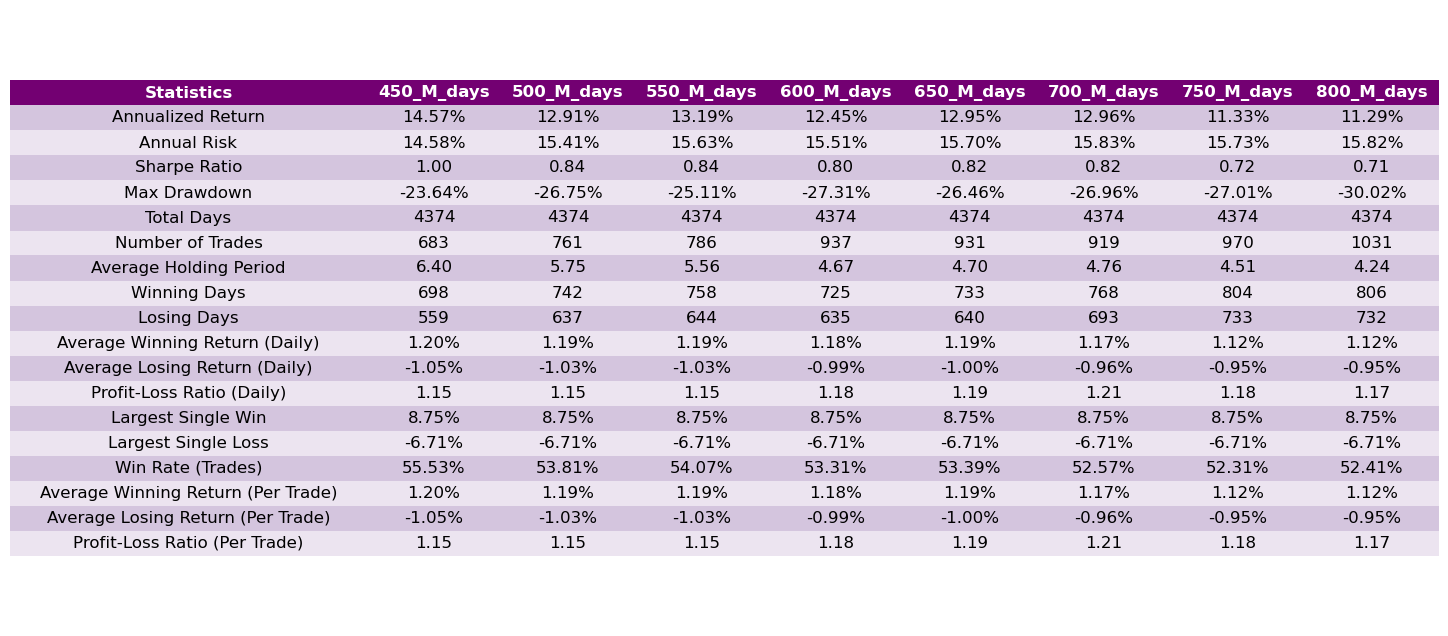

In [205]:
create_statistics_table((Multi_Factor['450_Cumulative_Strategy_Return'],Multi_Factor['450_Strategy_Signal']),
(Multi_Factor['500_Cumulative_Strategy_Return'],Multi_Factor['500_Strategy_Signal']),
(Multi_Factor['550_Cumulative_Strategy_Return'],Multi_Factor['550_Strategy_Signal']),
(Multi_Factor['600_Cumulative_Strategy_Return'],Multi_Factor['600_Strategy_Signal']),
(Multi_Factor['650_Cumulative_Strategy_Return'],Multi_Factor['650_Strategy_Signal']),
(Multi_Factor['700_Cumulative_Strategy_Return'],Multi_Factor['700_Strategy_Signal']),
(Multi_Factor['750_Cumulative_Strategy_Return'],Multi_Factor['750_Strategy_Signal']),
(Multi_Factor['800_Cumulative_Strategy_Return'],Multi_Factor['800_Strategy_Signal']),labels = [f'{M}_M_days' for M in M_values])

Now we want to try M parameters from 200 to 550 

In [206]:
# Define the M values for the sensitivity analysis
M_values = [200, 250, 300, 350, 400, 450, 500, 550]
# Copy of the Market DataFrame
Multi_Factor = Market.copy()

# Execute the strategy
Multi_Factor = multi_factor_strategy(Multi_Factor, M_values)

# Display the results for the last few rows for checking
Multi_Factor.tail()

,open,high,low,close,volume,Daily_Return,Cumulative_Return,rsrs_beta,r_squared,rsrs_zscore,...,450_Strategy_Return,450_Cumulative_Strategy_Return,500_rsrs_zscore,500_Strategy_Signal,500_Strategy_Return,500_Cumulative_Strategy_Return,550_rsrs_zscore,550_Strategy_Signal,550_Strategy_Return,550_Cumulative_Strategy_Return
date,,,,,,,,,,,,,,,,,,,,,
2022-12-26,3830.568,3856.807,3827.519,3843.489,7300571200,0.003989,3.910778,0.890240,0.892293,-0.095173,...,0.0,10.59469,-0.038868,0.0,0.0,8.223435,-0.103181,0.0,0.0,8.594629
2022-12-27,3860.905,3891.850,3856.580,3887.854,7751535000,0.011543,3.955920,0.964048,0.901101,0.495944,...,0.0,10.59469,0.553001,0.0,0.0,8.223435,0.493789,0.0,0.0,8.594629
2022-12-28,3874.913,3884.721,3854.941,3871.264,8442465600,-0.004267,3.939039,0.960882,0.895619,0.473518,...,-0.0,10.59469,0.528293,0.0,-0.0,8.223435,0.468748,0.0,-0.0,8.594629
2022-12-29,3854.236,3868.293,3838.480,3856.701,7939481500,-0.003762,3.924221,0.974884,0.899118,0.588703,...,-0.0,10.59469,0.640934,0.0,-0.0,8.223435,0.582429,0.0,-0.0,8.594629
2022-12-30,3873.936,3887.553,3868.757,3871.634,7877327200,0.003872,3.939416,0.978624,0.891949,0.621841,...,0.0,10.59469,0.671010,0.0,0.0,8.223435,0.613257,0.0,0.0,8.594629


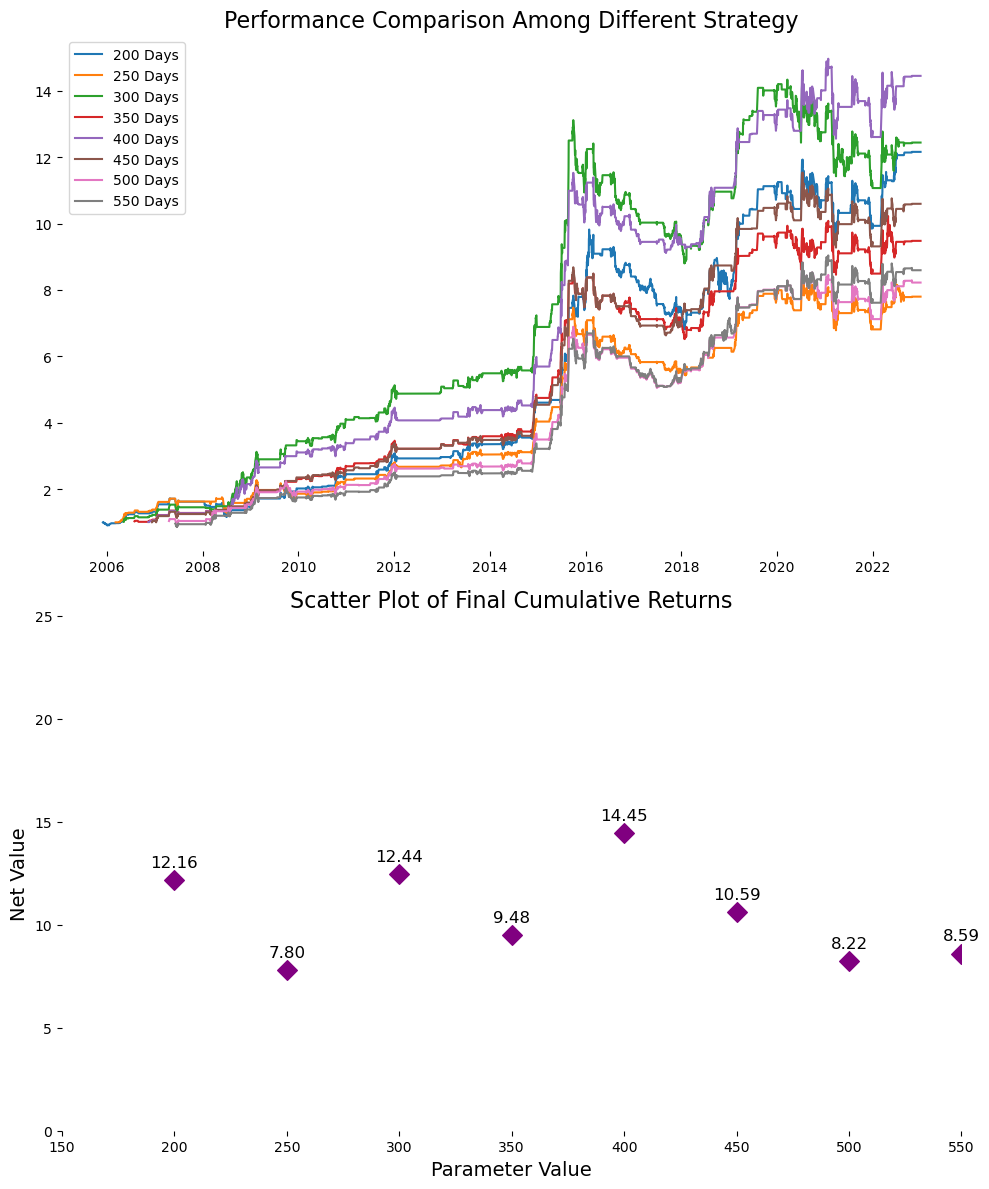

In [207]:

# Create a figure and two subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize=(10, 12))  # Adjust the figure size as needed

# First plot (line plot)
for M in M_values:
    ax[0].plot(Multi_Factor[f'{M}_Cumulative_Strategy_Return'], label=f"{M} Days")

ax[0].set_title("Performance Comparison Among Different Strategy", fontsize=16)
ax[0].legend()
for spine in ax[0].spines.values():
    spine.set_visible(False)

# Second plot (scatter plot)
A = []
for M in M_values:
    A.append(f'{M}_Cumulative_Strategy_Return')
values = Multi_Factor.iloc[-1][A].values

ax[1].scatter(M_values, values, color='purple', marker='D', s=100)

# Annotate each point with its value, moving the text slightly upward
for i, value in enumerate(values):
    ax[1].text(200 + i * 50, value + 0.5, f'{value:.2f}', fontsize=12, ha='center', va='bottom')

ax[1].set_xlim(150, 550)
ax[1].set_ylim(0, 25)
ax[1].set_title("Scatter Plot of Final Cumulative Returns", fontsize=16)
ax[1].set_xlabel("Parameter Value", fontsize=14)
ax[1].set_ylabel("Net Value", fontsize=14)
for spine in ax[1].spines.values():
    spine.set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the combined plot
plt.show()


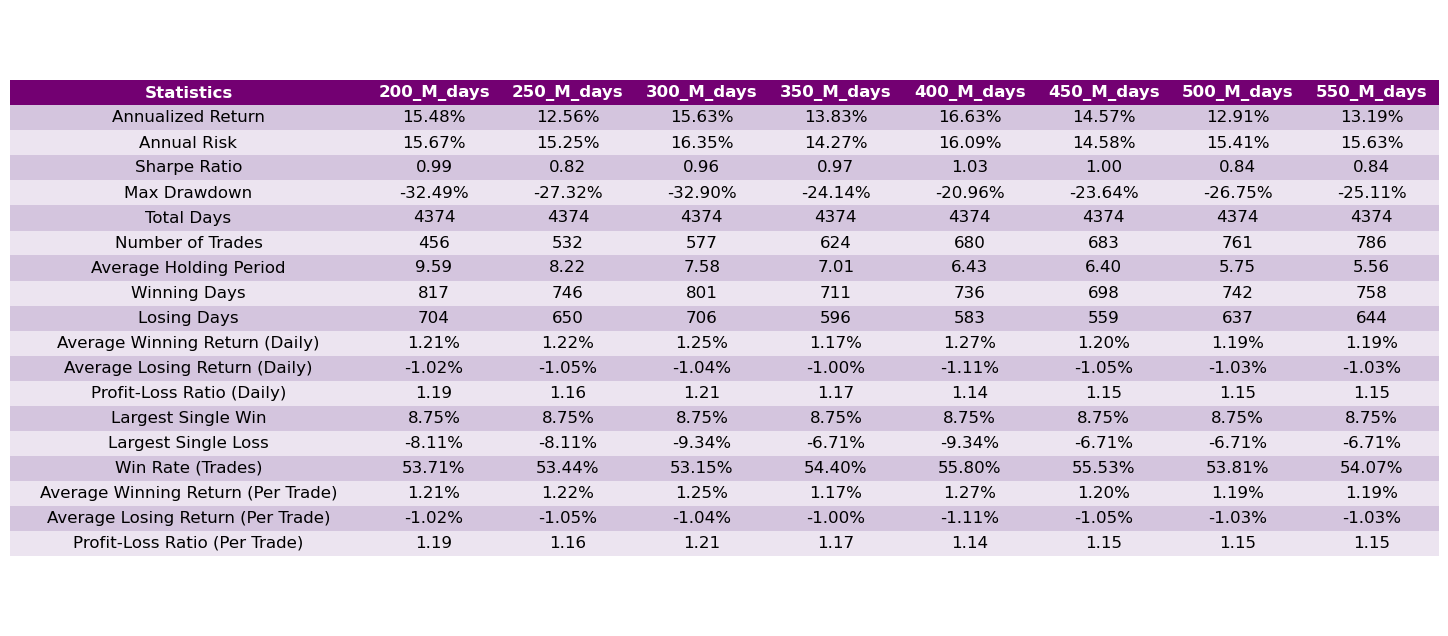

In [208]:
create_statistics_table((Multi_Factor['200_Cumulative_Strategy_Return'],Multi_Factor['200_Strategy_Signal']),
(Multi_Factor['250_Cumulative_Strategy_Return'],Multi_Factor['250_Strategy_Signal']),
(Multi_Factor['300_Cumulative_Strategy_Return'],Multi_Factor['300_Strategy_Signal']),
(Multi_Factor['350_Cumulative_Strategy_Return'],Multi_Factor['350_Strategy_Signal']),
(Multi_Factor['400_Cumulative_Strategy_Return'],Multi_Factor['400_Strategy_Signal']),
(Multi_Factor['450_Cumulative_Strategy_Return'],Multi_Factor['450_Strategy_Signal']),
(Multi_Factor['500_Cumulative_Strategy_Return'],Multi_Factor['500_Strategy_Signal']),
(Multi_Factor['550_Cumulative_Strategy_Return'],Multi_Factor['550_Strategy_Signal']),labels = [f'{M}_M_days' for M in M_values])

In [209]:
Multi_Factor

,open,high,low,close,volume,Daily_Return,Cumulative_Return,rsrs_beta,r_squared,rsrs_zscore,...,450_Strategy_Return,450_Cumulative_Strategy_Return,500_rsrs_zscore,500_Strategy_Signal,500_Strategy_Return,500_Cumulative_Strategy_Return,550_rsrs_zscore,550_Strategy_Signal,550_Strategy_Return,550_Cumulative_Strategy_Return
date,,,,,,,,,,,,,,,,,,,,,
2005-01-04,994.769,994.769,980.658,982.794,741286894,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,981.577,997.323,979.877,992.564,711910898,0.009941,1.009941,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-06,993.331,993.788,980.330,983.174,628802905,-0.009460,1.000387,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-07,983.045,995.711,979.812,983.958,729869409,0.000797,1.001184,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-10,983.760,993.959,979.789,993.879,579169799,0.010083,1.011279,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,3830.568,3856.807,3827.519,3843.489,7300571200,0.003989,3.910778,0.890240,0.892293,-0.095173,...,0.0,10.59469,-0.038868,0.0,0.0,8.223435,-0.103181,0.0,0.0,8.594629
2022-12-27,3860.905,3891.850,3856.580,3887.854,7751535000,0.011543,3.955920,0.964048,0.901101,0.495944,...,0.0,10.59469,0.553001,0.0,0.0,8.223435,0.493789,0.0,0.0,8.594629
2022-12-28,3874.913,3884.721,3854.941,3871.264,8442465600,-0.004267,3.939039,0.960882,0.895619,0.473518,...,-0.0,10.59469,0.528293,0.0,-0.0,8.223435,0.468748,0.0,-0.0,8.594629


### 